In [1]:
import math
#import itertools
import numpy as np
import matplotlib.pyplot as plt

#import plotly
#import plotly.express as px

from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import tqdm
#from functools import lru_cache
#import re
import networkx as nx
#from networkx.algorithms import approximation


import MDAnalysis as mda

#import scipy
#import sklearn
#import skimage

#import xml.etree.ElementTree as et
#from Bio.PDB import *
import nglview as nv

from timeit import default_timer as timer


import torch

import dask




# database to handle data

# in function, use dataframe and then pick right data


# http://nglviewer.org/nglview/latest/api.html
# https://biopython.org/wiki/The_Biopython_Structural_Bioinformatics_FAQ
# https://ambermd.org/tutorials/analysis/tutorial_notebooks/nglview_notebook/index.html
# https://amber-md.github.io/pytraj/latest/_api/pytraj.html

_ColormakerRegistry()

In [2]:
#contact_matrix = np.loadtxt('/home/lillo/TesiCNTE/CNTE/dataset/contact_matrix.txt')   #laptop
#contact_matrix = np.loadtxt('/home/lillo/Code/Tesi/dataset/contact_matrix.txt')        #fisso
#contact_matrix_single = contact_matrix.reshape(100,100,12,12)

#gromacs_output = open('/home/lillo/Code/Tesi/dataset/dm4500Compl_mix1_K2_1%4500ns.gro') #fisso
#gromacs_output = open('/home/lillo/TesiCNTE/CNTE/dataset/dm4500Compl_mix1_K2_1%4500ns.gro') #laptop

#path = '/home/lillo/Code/Tesi/dataset/dm4500Compl_mix1_K2_1%4500ns.gro' #fisso
#path = '/home/lillo/TesiCNTE/CNTE/dataset/dm4500Compl_mix1_K2_1%4500ns.gro' #laptop

# import 2mxu file (beta sheet)

#path_to_mmCIF = open('/home/lillo/TesiCNTE/pdb/2mxu/2mxu.cif')  ## laptop
#path_to_pdb = '/home/lillo/TesiCNTE/pdb/2mxu/2mxu.pdb'  ## laptop
#pa_to_pdb = '/home/lillo/TesiCNTE/pdb/2mxu/2mxu.pdb'  ## laptop

#path_to_mmCIF = open('/home/lillo/Code/Tesi/pdb/2mxu/2mxu.cif')  ## fisso
#path_to_pdb = '/home/lillo/Code/Tesi/pdb/2mxu/2mxu.pdb'  ## fisso
#pa_to_pdb = '/home/lillo/Code/Tesi/pdb/2mxu/2mxu.pdb'  ## fisso

# aggregate blob

#seed_1_path = '/home/lillo/TesiCNTE/from_cluster/aggregate1.gro' # laptop
#seed_1_path = '/home/lillo/Code/Tesi/dataset/aggregate1.gro' # Fisso

# Trajectory with aggregate seed
#trj_xtc = '/home/lillo/TesiCNTE/CNTE/trajectory/prd-LDLK12-100mer-out-mol.xtc'  #laptop
#trj_gro = '/home/lillo/TesiCNTE/CNTE/trajectory/min-LDLK12-100mer-out-c.gro'  #laptop

#n_trj_xtc = '/home/lillo/Code/Tesi/dataset/trajectory_6_12_19/prd-LDLK12-100mer-out-mol.xtc'  #fisso
#n_trj_gro = '/home/lillo/Code/Tesi/dataset/trajectory_6_12_19/min-LDLK12-100mer-out-c.gro'  #fisso


#prod_trr = '/home/lillo/TesiCNTE/from_cluster/prod/prod.trr'   # laptop
#prod_tpr = '/home/lillo/TesiCNTE/from_cluster/prod/prod.tpr'   # laptop

# part 1
prod_xtc = '/home/lillo/TesiCNTE/from_cluster/prod/prod_part1/prod.xtc'   # laptop
prod_gro = '/home/lillo/TesiCNTE/from_cluster/prod/prod_part1/min.gro'    # laptop

# part 2
prod1_xtc = '/home/lillo/TesiCNTE/from_cluster/prod/prod_part2/prod-compl.xtc' #laptop
prod1_gro = '/home/lillo/TesiCNTE/from_cluster/prod/prod_part2/prod-compl.gro' #laptop





In [ ]:
# READ .gro FILE AND PREPROCESSING

def clean_gro(path):
    
    
        # open file .gro and return a list with one element per line of the .gro file
    def read_gro(path):
        gromacs_output = open(path)

        gro_file = []
        for line in tqdm.tqdm(gromacs_output):
            gro_file.append(line)



        gromacs_output.close()        

        return gro_file



    # return string in a string with numbers
    def return_if_string(string):
        digits = []
        for i in string:
            if not i.isdigit():
                digits.append(i)

        string = ''.join(digits)

        return string


    # return numbers in a string with numbers
    def return_if_digit(string):
        digits = []
        for i in string:
            if i.isdigit():
                digits.append(i)

        string = ''.join(digits)

        return string


    # remove first, second and last lines from gro_file and reorder information
    # FIX OPTION TO GET ENTRY RELATED TO A LABEL (as 'bb' or 'ca')
    def clean_gro_file(gro_file):
        cleaned_gro_file = []
        for aminoacid in tqdm.tqdm(gro_file[2:-1]):
            splitted = aminoacid.split()
            if splitted[1] == 'BB':
                position_in_peptide = return_if_digit(splitted[0])
                residue = return_if_string(splitted[0])
                index = splitted[2]
                x = splitted[3]
                y = splitted[4]
                z = splitted[5]
                cleaned_gro_file.append([index, position_in_peptide, residue, x, y, z])
        return cleaned_gro_file
    
    
    gro_file = read_gro(path)
    cleaned_gro_file = clean_gro_file(gro_file)

    return cleaned_gro_file


# create coordinate dict from cleaned_gro_file
def get_coordinate_dict_from_cleaned_gro(cleaned_gro_file):
    
    peptide_lenght_list = []

    temporary_list = []

    # iterate trough cleaned_gro_file
    for residue in cleaned_gro_file:

        # if temporary list just started, add aminoacid position in chain
        if len(temporary_list) == 0:
            temporary_list.append(int(residue[1]))

        else:
            # if position of actual residue is less than last residue
            if temporary_list[-1] > int(residue[1]):

                # append lenght of last peptide to peptide lenght list
                peptide_lenght_list.append(len(temporary_list))

                # empty temporary list
                temporary_list = []

                # append actual residue position
                temporary_list.append(int(residue[1]))

            # if position of actual residue is higher than last residue, ad current residue position
            else:
                temporary_list.append(int(residue[1]))

    # append last peptide lenght to lenght stack
    peptide_lenght_list.append(len(temporary_list))

    # create empty dict for coordinate
    peptide_coordinate_dict = {}

    # create an entry in dict for every peptide in the file
    for peptide in range(len(peptide_lenght_list)):
        peptide_coordinate_dict[peptide] = {}

        # for every residue in lenght peptide, add coordinate x, y, z
        for residue in range(peptide_lenght_list[peptide]):
            peptide_coordinate_dict[peptide][residue] = [float(coordinate) for coordinate in cleaned_gro_file[(peptide * peptide_lenght_list[peptide])+residue][3:]]

    return peptide_coordinate_dict


# compute euclidean distance
def get_euclidean_distance(point_1, point_2):
    
    euclidean_distance = np.sqrt(np.sum([((point_1[0] - point_2[0])**2), ((point_1[1] - point_2[1])**2), ((point_1[2] - point_2[2])**2)]))

    return euclidean_distance

# compute distance map between two peptides
def compute_distance_map(coordinate_dict, peptide_1, peptide_2):

    distance_map = []
    for amino_1 in coordinate_dict[peptide_1]:
        coordinate_1 = coordinate_dict[peptide_1][amino_1]
        
        distance_map.append([amino_1])
        
        for amino_2 in coordinate_dict[peptide_2]:
            coordinate_2 = coordinate_dict[peptide_2][amino_2]
            
            euclidean_distance = get_euclidean_distance(coordinate_1, coordinate_2)
            distance_map[amino_1].append(euclidean_distance)
        
        del distance_map[amino_1][0]

    distance_map = np.asarray(distance_map)
    
    return distance_map

# compute distance map and return a n_peptide x n_peptide x n_res x n_res array
def compute_distance_maps_from_coordinate_dict(coordinate_dict):
    
    aggregate_distance_map = []

    #for peptide_1 in tqdm.tqdm(coordinate_dict):
    for peptide_1 in coordinate_dict:
        aggregate_distance_map.append([peptide_1])
        
        #for peptide_2 in tqdm.tqdm(coordinate_dict):
        for peptide_2 in coordinate_dict:
            distance_map = compute_distance_map(coordinate_dict, peptide_1, peptide_2)
            
            aggregate_distance_map[peptide_1].append(distance_map)

        del aggregate_distance_map[peptide_1][0]

    aggregate_distance_array = np.asarray(aggregate_distance_map)
    
    return aggregate_distance_array


# COMPUTE CONTACT MAPS
# TO DO: parametrize the threshold distance in a better way (e.g. )
def compute_contact_maps_as_array(distance_maps_array):
    
    # distance between the first and the second aminoacid of the first chain
    intrapeptide_minimum_distance = distance_maps_array[0][0][0][1] 

    contact_map_list = []

    # contact is in a distance up to 150% of the intrapeptide_minimum_distance [TO IMPROVE!!!]
    threshold_distance = (intrapeptide_minimum_distance * 1.5)

    for model_1 in range(distance_maps_array.shape[0]):
        contact_map_list.append([])
        for model_2 in range(distance_maps_array[model_1].shape[0]):

            contact_map_list[model_1].append([])

            if model_1 == model_2:

                contact_map_list[model_1][model_2].extend(np.zeros((distance_maps_array.shape[2], distance_maps_array.shape[3])))

            else:

                contact_map = np.zeros((distance_maps_array.shape[2], distance_maps_array.shape[3]))

                for chain_1 in range(distance_maps_array[model_1][model_2].shape[0]):

                    for chain_2 in range(distance_maps_array[model_1][model_2][chain_1].shape[0]):

                        distance = distance_maps_array[model_1][model_2][chain_1][chain_2]

                        if distance < threshold_distance:
                            contact_map[chain_1][chain_2] = 1 #True
                        else:
                            pass

                contact_map_list[model_1][model_2].extend(contact_map)
    
    contact_array = np.asarray(contact_map_list)
            
    return contact_array


#### ANALYSIS

def shift_library_maker(contact_map_to_analyze):
    
    ''' riceve numero di righe e di colonne
    restituisce un array shape((((row + col)*2)-2),row,col).
    ogni slice è una diagonale. Lo stack copre le diagonali su tutta la matrice'''
    
    row = contact_map_to_analyze.shape[0]
    col = contact_map_to_analyze.shape[1]
    
    kron_dict = {}
    kron_list_parallel = []
    kron_list_antiparallel = []
    
    for e in range(-row+1, col):
        array = np.eye(row, col, e)
        kron_list_parallel.append(array)
        kron_list_antiparallel.append(np.fliplr(array))
        
    kron_array_parallel = np.asarray(kron_list_parallel)
    kron_array_antiparallel = np.asarray(kron_list_antiparallel)
    
    kron_dict['parallel'] = kron_array_parallel
    kron_dict['antiparallel'] = kron_array_antiparallel
    
    return kron_dict


def normalized_cross_correlation_function(contact_map):
    '''
    Calculate normalized cross correlation function between a contact map and an ideal map.
    
    Arguments : contact map, as output from get_contact_maps function
                shift_matrix_stack, as output from shift_matrix_maker function
                
    Return : a list [ncc_value, index (in the shift_matrix_stack) of the shift matrix
                that is matching the contact map
            
            '''
    shift_matrix_library = shift_library_maker(contact_map)
    
    cross_correlation_values = []
    max_val = []
    sum_contact_map = np.sum(contact_map)
    
    if sum_contact_map < 2:
        pass
    
    else:
        for sense in shift_matrix_library:
            for index, z in enumerate(shift_matrix_library[sense]):

                shift_matrix = shift_matrix_library[sense][index]
                sum_shift_matrix = np.sum(shift_matrix)
                ncc_value = (np.sum((contact_map * shift_matrix))/((np.sqrt(sum_contact_map))*(np.sqrt(sum_shift_matrix))))  # normalized cross correlation function of contact matrix and shift matrix
                cross_correlation_values.append([ncc_value, index, sum_contact_map, sense])

            max_val = max(cross_correlation_values) # get only the best match (highest value of ncc)

    return max_val



def normalized_cross_correlation_for_dataset(contact_array):
    '''Calculate normalized cross correlation function between the full contacts map and and the .
    
    Arguments : contact map, as output from get_contact_maps function
                shift_matrix_stack, as output from shift_matrix_maker function
                
    Return : a list [ncc_value, index (in the shift_matrix_stack) of the shift matrix that is matching the contact map'''
    
    contact_dict = {}
    
    #for row in tqdm.tqdm(range(contact_array.shape[0])):
    for row in range(contact_array.shape[0]):
    
        for col in range((row+1), contact_array.shape[1]):
        #for col in range(contact_array.shape[1]):

            best_match = []
            best_match = normalized_cross_correlation_function(contact_array[row][col])
            
            if len(best_match) == 0:
                pass
            
            else:
                if row in contact_dict:
                    contact_dict[row].append([row, col, best_match])
                
                else:
                    contact_dict[row] = [[row, col, best_match]]
    
    return contact_dict


#denoise dataset
def denoise_full_dataset(contact_maps, normalized_cross_correlation_results):
    
    '''Denoise the contact_maps dataset using the shift_matrix
    
    Arguments : contact_maps, normalized_cross_correlation_result
    
    return : a dict with key:value = row : row, col, denoised_map
    
    '''

    denoised_dict = {}

    for peptide_1 in normalized_cross_correlation_results:
        denoised_dict[peptide_1] = {}
        for index, peptide_2 in enumerate(normalized_cross_correlation_results[peptide_1]):

            row = peptide_2[0]
            col = peptide_2[1]



            contact_map = contact_maps[row][col]
            sense = peptide_2[2][3]
            shift_matrix_index = normalized_cross_correlation_results[peptide_1][index][2][1]

            shift_matrix = shift_library_maker(contact_map)
            shift_matrix = shift_matrix[sense][shift_matrix_index]
            denoised_map = contact_map * shift_matrix

            denoised_dict[row][col] = denoised_map
            
    return denoised_dict


#create a dict that contains the peptide couples contact and the specular peptide couples contact
def reconstruct_full_matrix(denoised_dict):
    full_denoised_dict = {}
    for peptide_1 in tqdm.tqdm(denoised_dict):
        for peptide_2 in denoised_dict[peptide_1]:
            contact_map = denoised_dict[peptide_1][peptide_2]

            if peptide_1 in full_denoised_dict:
                full_denoised_dict[peptide_1][peptide_2] = contact_map

            if peptide_1 not in full_denoised_dict:
                full_denoised_dict[peptide_1] = {peptide_2:contact_map}

            if peptide_2 in full_denoised_dict:
                full_denoised_dict[peptide_2][peptide_1] = contact_map.T

            if peptide_2 not in full_denoised_dict:
                full_denoised_dict[peptide_2] = {peptide_1:contact_map.T}
    
    return full_denoised_dict


# take array, return vector with sum along columns
def get_row_vector(array):
    row_vector = np.sum(array, axis=0)
    return row_vector

# take array, return vector with sum along row
def get_col_vector(array):
    col_vector = np.sum(array, axis=1)
    return col_vector

# graph clustering
def nx_graph_search(denoised_dict):
    
    graph = nx.MultiGraph()
    
    for peptide_1 in denoised_dict:
        for peptide_2 in denoised_dict[peptide_1]:
            array_1 = denoised_dict[peptide_1][peptide_2]
            for peptide_3 in denoised_dict[peptide_2]:
                if peptide_3 != peptide_1:
                    array_2 = denoised_dict[peptide_2][peptide_3]

                    vect_1 = get_row_vector(array_1)
                    vect_2 = get_col_vector(array_2)

                    contacts = np.dot(vect_1, vect_2)
                    
                    if contacts >= 3:

                        graph.add_edge(peptide_1, peptide_2)
                     
                        graph.add_edge(peptide_2, peptide_3)

    return graph

#A novel graph clustering algorithm based on discrete-time quantum random walk
#S.G. Roya, A. Chakrabarti


# working with networkX
# if contacts >= target

# when you add_edge, nodes are created if they are not there
# you can put info in edge (as distance, n of contacts, contact map)
# you HAVE TO (but you can not also) put key to index multiple nodes that are joined with a single node
# 
# add edge from pep1 to pep2 (you HAVE TO (###to explore utility of key) put key to index multiple nodes that are joined with a single node)
# add edge from pep3 to pep3 ( same as before with key)


#FIND SUBGRAPH
def find_subgraph(graph):
    '''
    Find subgraph that have no node in common.
    
    Argument: NetworkX MultiGraph
    
    Return: list of subgraph ordered from one end to the other
    
    '''

    subgraph_list = []
    
    for node in graph:
        
        # don't explore node that are already in subgraph_list
        if node not in set(nod for nod_list in subgraph_list for nod in nod_list):
            
            # tree is the list of nodes joined to node, starting from node
            # using depht first search
            tree = [e for e in nx.algorithms.traversal.depth_first_search.dfs_tree(graph, node)]
            
            # check if the first node of the tree has adjiacency == 1
            # so it checks if it is the first or last node of the subgraph
            if len(graph[tree[0]]) == 1:
                
                if len(subgraph_list) == 0:
                    subgraph_list.append(tree)
                    
                else:
                    # use generator to check if the tree is already in the subgraph
                    if set(tree) not in (set(i) for i in subgraph_list):
                        subgraph_list.append(tree)
                        
    return subgraph_list


########## PLOT PEPTIDE LIST
# plot a list of peptide point cloud in 3d space.
# The box axis have arbitrary scale dependent on the aminoacids distance
# you can select to show the centroid
def plot_peptide_list(coordinate_dict, peptide_list, centroid=False):
    x = []
    y = []
    z = []
    x_median = float
    y_median = float
    z_median = float
    

    for peptide in range(len(peptide_list)):
        x.append([peptide])
        y.append([peptide])
        z.append([peptide])
        for aminoacid in coordinate_dict[peptide_list[peptide]]:

            point = coordinate_dict[peptide_list[peptide]][aminoacid]
            x[peptide].append(point[0])
            y[peptide].append(point[1])
            z[peptide].append(point[2])

        del x[peptide][0]
        del y[peptide][0]
        del z[peptide][0]
        
    if centroid == True:
        
        def assemble_coordinate(axis_coordinate_list):
            median_list = []
            for coordinate_set in axis_coordinate_list:
                median = np.median(coordinate_set)
                median_list.append(median)
            return median_list
        
        x_median = assemble_coordinate(x)
        y_median = assemble_coordinate(y)
        z_median = assemble_coordinate(z)
        

    #%matplotlib notebook

    fig = plt.figure()
    ax = plt.axes(projection='3d')
    
    for pep in range(len(x)):
       
        ax.scatter3D(x[pep],y[pep],z[pep])
        
        if centroid == True:
            
            ax.scatter3D(x_median[pep], y_median[pep], z_median[pep], c='red')
            
        
    #return  plt.show(), [x,y,z], [x_median, y_median, z_median]
    return  plt.show()



# get average distance map from distance maps set
def get_mean_distance_map(distance_maps):
    '''
    Calculate mean distance map from distance maps set
    
    Argument: distance maps set
    
    return: np.array with average intrapeptide distance
    
    '''
    
    # create array of zeros of shape number_of_residues * number_of_residues
    # depending on peptide residue number ### TO FIX FOR MULTIMONOMERIC ASSEMBLY
    base = np.zeros((distance_maps[0][0].shape[0], distance_maps[0][0].shape[1]))
    
    # initialize counter
    counter = 0
    
    # iterate throught peptides in the aggregate
    for peptide_1 in range(distance_maps.shape[0]):
        for peptide_2 in range(distance_maps.shape[1]):
             
            # if peptide index are the same (intrapeptide distance map)
            if peptide_1 == peptide_2:
                
                # intrapeptide distance map
                actual_distance_map = distance_maps[peptide_1][peptide_2]
                
                # sum base and current distance map
                base = base + actual_distance_map
                
                #update counter
                counter += 1

    #for element in base (every element is the sum of distance_map(i,j) for every distance map)
    for row in range(len(base)):
        for col in range(len(base)):
            
            # find the mean for every element of the cumulative distance map
            base[row][col] = (base[row][col])/counter
            
    return base


def decompose_distance_map(distance_map):
    '''Use Singular value decomposition to get
    
    distance_map.shape[1] dimensional coordinate
    (same n of dimension as the peptide n of residue)
    
    As described in:
    Mathematical Modeling of Protein Structure Using Distance Geometry
    Jeong-Mi Yoon, Yash Gad, Zhijun Wu
    
    Argument: distance map (numpy.array 2D)
    return: X : actual decomposition
            
    
    '''
    
    # initialize a zeros matrix of same shape as the input map
    D = np.zeros(distance_map.shape)
    
    #iterate trought row
    for i in range(distance_map.shape[0]):
        
        # iterate trought cols
        for j in range(distance_map.shape[1]):
            
            # distance between point point i and point j 
            dij = distance_map[i][j]
            
            # distance between point 0 and point j
            d0j = distance_map[0][j]
            
            #distance between point i and point 0
            di0 = distance_map[i][0]

            #fill the zeros matrix with the value obtained with this formula
            D[i][j] = (d0j**2 + di0**2 - dij**2)/2
            
    # check rank of matrix (should be of rank 3, but it is of rank distance_map.shape[1])
    rank = np.linalg.matrix_rank(D)
    
    # Singular value decomposition on the D matrix
    #svd = np.linalg.svd(D)
    
    svd = np.linalg.svd(D, full_matrices=False)
    
    # Calculate distance_map.shape[1] dimensional coordinate, but you need 3
    # the non necessary dimension can give data to better reconstruct the peptide structure
    X = svd[0]*np.sqrt(svd[1])

    
    #return X, svd, D, rank
    return X

def get_coordinate_from_decomposition(decomposition):
    '''Take decomposition result and convert it into a coordinate vectors dict
    
    Argument: decomposition results
    
    return: dict with reconstructed 3d coordinate vector
    
    '''
    
    # take only the first three value to compose a 3D coordinate vector
    coordinate = [e[:3] for e in decomposition]
    
    # initialize empty dict
    reconstructed_coordinate_dict = {}
    
    # fill the dict with the ccordinate vectors
    for index,coordinate_vector in enumerate(coordinate):
        reconstructed_coordinate_dict[index] = coordinate_vector
    
    return reconstructed_coordinate_dict


# 
def get_coordinate_from_distance_map(distance_map):
    ''' compute 3d coordinate from distance map
    
    Argument: distance_map (numpy.array)
    
    return: dict with 3d coordinate for every alpha-carbon of a peptide
    
    '''
    # perform singular value decomposition on distance_map (preprocessed)
    decomposed_mean_distance_map = decompose_distance_map(distance_map)
    
    
    # get 3D coordinate
    reconstructed_coordinate_dict = get_coordinate_from_decomposition(decomposed_mean_distance_map)
    
    return reconstructed_coordinate_dict

    
    
def plot_single_peptide(peptide_coordinate_dict, centroid=False):
    x = []
    y = []
    z = []
    
    for residue in peptide_coordinate_dict:
        point = peptide_coordinate_dict[residue]
        x.append(point[0])
        y.append(point[1])
        z.append(point[2])


    x = np.asarray(x)
    y = np.asarray(y)
    z = np.asarray(z)
    
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    ax.scatter3D(x,y,z, c='b')
    
    if centroid == True:
            median_centroid = [np.median(x), np.median(y), np.median(z)]
            ax.scatter3D(median_centroid[0], median_centroid[1], median_centroid[2], c='r')
            
    return plt.show()


In [ ]:
# open and clean .gro file
# return list with an entry for every residue plus info
start = timer()
cleaned_gro_seed_1 = clean_gro(seed_1_path)
end = timer()
print(end - start)

# return a dict with residue coordinate
start = timer()
coordinate_dict_seed_1 = get_coordinate_dict_from_cleaned_gro(cleaned_gro_seed_1)
end = timer()
print(end - start)

# compute distance maps and return a n_peptide x n_peptide x n_res x n_res array ## from .gro coordinate dict
start = timer()
distance_maps_seed_1 = compute_distance_maps_from_coordinate_dict(coordinate_dict_seed_1)
end = timer()
print(end-start)

# compute contact maps from distance maps
start = timer()
contact_maps_seed_1 = compute_contact_maps_as_array(distance_maps_seed_1)
end = timer()
print(end-start)

# compute cross correlation and get values
start = timer()
normalized_cross_correlation_results_seed_1 = normalized_cross_correlation_for_dataset(contact_maps_seed_1)
end = timer()
print(end-start)

# denoise dataset
start = timer()
denoised_dict_seed_1 = denoise_full_dataset(contact_maps_seed_1, normalized_cross_correlation_results_seed_1)
end = timer()
print(end-start)

# recreate full contact map dataset mirrroring the upper triangle
# return dict
start = timer()
full_denoised_dict_seed_1 = reconstruct_full_matrix(denoised_dict_seed_1)
end = timer()
print(end-start)

#create graph
start = timer()
graph_seed_1 = nx_graph_search(full_denoised_dict_seed_1)
end = timer()
print(end-start)

#search subgraph
start = timer()
subgrap_list_seed_1 = find_subgraph(graph_seed_1)
end = timer()
print(end-start)

#find mean distance map
start = timer()
mean_distance_map_seed_1 = get_mean_distance_map(distance_maps_seed_1)
end = timer()
print(end-start)

# decompose mean distance matrix
start = timer()
decomposed_mean_distance_map = decompose_distance_map(mean_distance_map_seed_1)
end = timer()
print(end-start)
      
# get coordinate from distance map      
start = timer()
reconstructed_coordinate_dict = get_coordinate_from_decomposition(decomposed_mean_distance_map)
end = timer()
print(end-start)


In [ ]:
# RUN THIS FOR 3D VIEW OF PLOT

%matplotlib notebook

In [ ]:
# RUN THIS TO CLOSE ALL PLOT (run multiple time this cell if it does not work)
plt.close()

In [ ]:
# plot the reconstructed average peptide 
plot_single_peptide(reconstructed_coordinate_dict)

In [ ]:
# plot full coordinate from dict
plot_peptide_list(coordinate_dict_seed_1, [e for e in coordinate_dict_seed_1])

In [ ]:
### TRAJECTORY

# using mdanalysis module


#create Universe from a .gro with coordinates and an .xtc with the trajectory data
u = mda.Universe(trj_gro,trj_xtc)

In [ ]:
# create a dict from a Universe in which each entry is a timestep of the MD simulation
def create_trajectory_dict(u):
    bb = u.select_atoms('name BB')
    trajectory_dict = {}
    for index, time_steps in enumerate(u.trajectory):
        trajectory_dict[index] = bb.positions
    return trajectory_dict

# make trajectory dict
trajectory_dict = create_trajectory_dict(u)

In [ ]:
#if you change the number in the first parentesis, you change timestep
#second parentesis are the bb grains
pep = trajectory_dict[0][:1200] # this are all the coordinate of bb grains of timestep 0, as an array

#cast coordinate from array to dict
zero_c = get_coordinate_from_decomposition(pep)

#plot dict as a single object
plot_single_peptide(zero_c)

In [ ]:
# To see the trajectory you need to install ngl-view
# https://github.com/arose/nglview
#
# pay attention to this:
#   pip install nglview
#
# in a terminal, in the env where ngl-view is installed, send this:
# jupyter-nbextension enable nglview --py --sys-prefix
#


view = nv.show_mdanalysis(u)

In [ ]:
view

In [3]:
class morphoscanner():
    
    
    
    class math_utility():

        # take array, return vector with sum along columns
        def get_row_vector(array):
            row_vector = np.sum(array, axis=0)
            return row_vector

        # take array, return vector with sum along row
        def get_col_vector(array):
            col_vector = np.sum(array, axis=1)
            return col_vector
        
        
    class utility():
        
        def get_coordinate_dict_from_array(array):
            '''Take decomposition result and convert it into a coordinate vectors dict

            Argument: decomposition results

            return: dict with reconstructed 3d coordinate vector

            '''

            # make list with n == array.shape[0]
            coordinate = [e for e in array]

            # initialize empty dict
            reconstructed_coordinate_dict = {}

            # fill the dict with the ccordinate vectors
            for index,coordinate_vector in enumerate(coordinate):
                reconstructed_coordinate_dict[index] = coordinate_vector

            return reconstructed_coordinate_dict
        
        
        
        def contact_list_from_dict(contact_dict):
            
            contact_list = []
            for peptide in contact_dict:

                for contact in contact_dict[peptide]:

                    new_data = [contact[0], contact[1], contact[2][0], contact[2][1], contact[2][2], contact[2][3]]
                    contact_list.append(new_data)
            return contact_list

    
    
    
    class read():
        
        # READ .gro FILE AND PREPROCESSING

        def clean_gro(path):


                # open file .gro and return a list with one element per line of the .gro file
            def read_gro(path):
                gromacs_output = open(path)

                gro_file = []
                for line in gromacs_output:
                    gro_file.append(line)



                gromacs_output.close()        

                return gro_file



            # return string in a string with numbers
            def return_if_string(string):
                digits = []
                for i in string:
                    if not i.isdigit():
                        digits.append(i)

                string = ''.join(digits)

                return string


            # return numbers in a string with numbers
            def return_if_digit(string):
                digits = []
                for i in string:
                    if i.isdigit():
                        digits.append(i)

                string = ''.join(digits)

                return string


            # remove first, second and last lines from gro_file and reorder information
            # FIX OPTION TO GET ENTRY RELATED TO A LABEL (as 'bb' or 'ca')
            def clean_gro_file(gro_file):
                cleaned_gro_file = []
                for aminoacid in gro_file[2:-1]:
                    splitted = aminoacid.split()
                    if splitted[1] == 'BB':
                        position_in_peptide = return_if_digit(splitted[0])
                        residue = return_if_string(splitted[0])
                        index = splitted[2]
                        x = splitted[3]
                        y = splitted[4]
                        z = splitted[5]
                        cleaned_gro_file.append([index, position_in_peptide, residue, x, y, z])
                return cleaned_gro_file


            gro_file = read_gro(path)
            cleaned_gro_file = clean_gro_file(gro_file)

            return cleaned_gro_file
        
        # create coordinate dict from cleaned_gro_file
        def get_coordinate_dict_from_cleaned_gro(cleaned_gro_file):

            peptide_lenght_list = []

            temporary_list = []

            # iterate trough cleaned_gro_file
            for residue in cleaned_gro_file:

                # if temporary list just started, add aminoacid position in chain
                if len(temporary_list) == 0:
                    temporary_list.append(int(residue[1]))

                else:
                    # if position of actual residue is less than last residue
                    if temporary_list[-1] > int(residue[1]):

                        # append lenght of last peptide to peptide lenght list
                        peptide_lenght_list.append(len(temporary_list))

                        # empty temporary list
                        temporary_list = []

                        # append actual residue position
                        temporary_list.append(int(residue[1]))

                    # if position of actual residue is higher than last residue, ad current residue position
                    else:
                        temporary_list.append(int(residue[1]))

            # append last peptide lenght to lenght stack
            peptide_lenght_list.append(len(temporary_list))

            # create empty dict for coordinate
            peptide_coordinate_dict = {}

            # create an entry in dict for every peptide in the file
            for peptide in range(len(peptide_lenght_list)):
                peptide_coordinate_dict[peptide] = {}

                # for every residue in lenght peptide, add coordinate x, y, z
                for residue in range(peptide_lenght_list[peptide]):
                    peptide_coordinate_dict[peptide][residue] = [float(coordinate) for coordinate in cleaned_gro_file[(peptide * peptide_lenght_list[peptide])+residue][3:]]

            return peptide_coordinate_dict #, peptide_lenght_list
        
        
        def get_coordinate_dict_from_cleaned_gro_for_fixed_lenght_peptides(cleaned_gro_file, peptide_lenght):
            '''Works only with system made of peptide of equal peptide length
                (the peptide in the trajectory have all the same number of aminoacids).

            Usefull to disassemble premade aggregate in a system of omogenous peptide lenght'''

            peptide_coordinate_dict = {}

            for peptide in range(len(cleaned_gro_file)//peptide_lenght):

                peptide_coordinate_dict[peptide] = {}

                peptide_data = cleaned_gro_file[(peptide*peptide_lenght):((peptide*peptide_lenght)+peptide_lenght)]

                for index, amino in enumerate(peptide_data):

                    peptide_coordinate_dict[peptide][index] = [float(amino[3]), float(amino[4]), float(amino[5])] ## can you generalize this 3? Maybe with re or isdigit function??

            return peptide_coordinate_dict
        
        
        
    
    
    
    
    
    
    
    class dataframe():
        
        
        def get_dataframe_from_trajectory(trj_gro, trj_xtc, peptide_length = None):
            
            '''Create pandas.DataFrame from trajectory files
            
            Arguments: str(.gro topology path),
                       str(.xtc trajectory path),
                       int (optional)
                       
            output: pandas.DataFrame
            
            The 3rd argument (peptide_length) is optional. If you leave it empty the
            function will use the topology file to dynamically group residues into peptides,
            strictly following the topology. It adapt to different peptide lengths (aminoacids number in the peptide)
            
            
            If you do molecular dynamics simulation with peptide of fixed residues number,
            you can insert the residues number and the function will parse the residues to
            compose the peptides unsing that number.
            
            for example, you use peptides with 12 aminoacids each, but you start your simulation
            using a premade seed of 4 peptides forming a beta-sheet. The gromacs topology file will
            consider this as a 64 residues peptide. But it is actually made of 4 peptides of 12 aminoacid each.
            If you set the peptide_length to 12, it will parse the premade beta sheet 
            as 4 peptides of 12 aminoacids each.
            
            '''

            universe = morphoscanner.topology.make_universe(trj_gro, trj_xtc)

            topology = trj_gro

            peptides_list = morphoscanner.topology.get_peptide_length_list(trj_gro)


            if peptide_length == None:


                n_pep = len(peptides_list)


            else:

                n_pep = sum([(e//peptide_length) for e in peptides_list])

            #columns_name = ['atom_number','peptide_number', 'residue_name', 'residue_position', 'coordinates']
            columns_name = ['time_step','peptide_number', 'residue_position', 'residue_name', 'atom_position', 'atom_type', 'coordinates']

            # create list for a pd.DataFrame
            # as suggested in https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.append.html
            for_pandas = []

            trj_dict = {}

            for index_ts, ts in enumerate(universe.trajectory):

                trj_dict[index_ts] = {}

                for peptide in range(n_pep):

                    trj_dict[index_ts][peptide] = {}

                    if peptide != 0:

                        # if to check peptide_length

                        if peptide_length == None:

                            counter += peptides_list[peptide - 1]

                        else:
                            counter += peptide_length


                    else:
                        counter = 0


                    if peptide_length == None:

                        for res in range(peptides_list[peptide]):

                            res_name = (str(universe.residues[res + counter]).split()[1].split(',')[0])#.split(',')[0])
                            res_position = int(str(universe.residues[res + counter]).split()[2].split('>')[0])#.split(',')[0])
                            res_id = str(res_position) + '_' + res_name

                            #print(str(universe.residues[res + counter]))

                            for index, atom in enumerate(universe.residues[res + (counter)].atoms):

                                #print(atom)

                                atom_number = (int(str(atom).split()[1].split(':')[0]) - 1)

                                atom_type = str(atom).split()[2]

                                coordinate = universe.atoms[atom_number].position

                                position = len(trj_dict[index_ts][peptide])

                                trj_dict[index_ts][peptide][position] = coordinate

                                #features = [atom_number,peptide, res_name, position, coordinate]
                                features = [index_ts, peptide, res_position, res_name, position, atom_type, coordinate]

                                for_pandas.append(features)

                    else:

                        for res in range(peptide_length):

                            res_name = (str(universe.residues[res + counter]).split()[1].split(',')[0])#.split(',')[0])
                            res_position = int(str(universe.residues[res + counter]).split()[2].split('>')[0]) - 1 # -1 to start index from 0
                            res_id = str(res_position) + '_' + res_name

                            #print(str(universe.residues[res + counter]))

                            for index, atom in enumerate(universe.residues[res + (counter)].atoms):

                                #print(atom)

                                atom_number = (int(str(atom).split()[1].split(':')[0]) - 1)

                                atom_type = str(atom).split()[2]

                                coordinate = universe.atoms[atom_number].position

                                position = len(trj_dict[index_ts][peptide])

                                trj_dict[index_ts][peptide][position] = coordinate

                                #features = [atom_number,peptide, res_name, position, coordinate]
                                features = [index_ts, peptide, res_position, res_name, position, atom_type, coordinate]

                                for_pandas.append(features)



            #start = timer()
            df = pd.DataFrame(for_pandas, columns=columns_name)
            #end = timer()
            #print(end-start)
            return df

    
    
        # get dataframe of bb grains for a frame ()
        def get_bb(dataframe, frame):
    
            bb_dataframe = dataframe.groupby('time_step').get_group(frame).groupby('atom_type').get_group('BB')

            return bb_dataframe
    
        
        
        
        
        def get_peptide_tensor_from_dataframe(dataframe, step, peptide):
            
            '''Get 2d tensor with the coordinate of every atom (or grain) of a peptide, from a dataframe
            
            
            Input:  dataframe, (the dataframe where your data are).
            
                    step, (frame of the trajectory from which you want to take the coordinate)
                    
                    peptide, (the peptide of which you want the coordinate)
                    
            Output: torch.tensor, of shape(n,3), where n is the number of atoms in the peptide
            that you are considering. And 3 are the coordinate x, y, z of the atom.
            '''
        
            device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

            peptide_data = dataframe.groupby('time_step').get_group(step).groupby('peptide_number').get_group(peptide)

            peptide_tensor = torch.tensor([vector for vector in peptide_data.coordinates.values], device=device)

            return peptide_tensor
    
    
        
        
        
        
        def distance_maps_from_dataframe(dataframe, time_step):
            
            '''Calculate distance maps for all the peptides in a step of the md simulation.
            
            Input:  pandas.DataFrame. Made with morphoscanner.dataframe.get_dataframe_from_trajectory()
                    
                    int. Timestep of the simulation
                    
                    
            Output: dict of tensor. len(dict)==number of peptide in the simulation
                                    len(dict[i])== number of peptide in the simulation
                                    tensor.shape == (number of residue in peptide1, number of residue in peptide2)
                                    
            '''
            
            
    
            device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

            number_of_peptides = len(dataframe.groupby('time_step').get_group(time_step).groupby('peptide_number'))
            #number_of_peptides = 5

            distance_dict = {}
            # iterate trought all peptides in a frame
            for peptide1 in range(number_of_peptides):

                if peptide1 not in distance_dict.keys():

                    distance_dict[peptide1] = {}

                else:
                    pass

                number_of_atoms_in_peptide1 = len(dataframe.groupby('time_step').get_group(time_step).groupby('peptide_number').get_group(peptide1))



                peptide1_tensor = morphoscanner.dataframe.get_peptide_tensor_from_dataframe(dataframe, time_step, peptide1)

                # iterate trought peptide in the upper triangle only
                for peptide2 in range(peptide1, number_of_peptides):


                    number_of_atoms_in_peptide2 = len(dataframe.groupby('time_step').get_group(time_step).groupby('peptide_number').get_group(peptide2))


                    peptide2_tensor = morphoscanner.dataframe.get_peptide_tensor_from_dataframe(dataframe, time_step, peptide2)


                    distance_map = morphoscanner.distance_tensor.distance_matrix_from_2d_tensor(peptide1_tensor, peptide2_tensor)
                    distance_dict[peptide1][peptide2] = distance_map

                    if peptide2 in distance_dict.keys():

                        #distance_dict[peptide2] = {}
                        distance_dict[peptide2][peptide1] = distance_map.transpose(1,0)

                    else:
                        distance_dict[peptide2] = {}
                        distance_dict[peptide2][peptide1] = distance_map.transpose(1,0)

            return distance_dict
        
        # SO YOU CAN CALCULATE DISTANCE MAPS
        # NOW YOU HAVE TO PUT THOSE IN A DATAFRAME

    #return dist

#https://discuss.pytorch.org/t/efficient-distance-matrix-computation/9065
#https://www.dropbox.com/h?preview=Parallel+Euclidean+distance+matrix+computation+on+big+datasets.pdf  
    
    
    
    
    
    
        
        
        
    
    
    

    class topology():
    
        
        #get a list of the number of residues of every peptide in the topology
        def get_peptide_length_list(topology):
            
            topology = morphoscanner.read.clean_gro(topology)
    
            peptide_lenght_list = []

            temporary_list = []

            # iterate trough topology
            for residue in topology:

                # if temporary list just started, add aminoacid position in chain
                if len(temporary_list) == 0:
                    temporary_list.append(int(residue[1]))

                else:
                    # if position of actual residue is less than last residue
                    if temporary_list[-1] > int(residue[1]):

                        # append lenght of last peptide to peptide lenght list
                        peptide_lenght_list.append(len(temporary_list))

                        # empty temporary list
                        temporary_list = []

                        # append actual residue position
                        temporary_list.append(int(residue[1]))

                    # if position of actual residue is higher than last residue, ad current residue position
                    else:
                        temporary_list.append(int(residue[1]))

            # append last peptide lenght to lenght stack
            peptide_lenght_list.append(len(temporary_list))

            return peptide_lenght_list
    
    
    
    
    
        def make_universe(trj_gro, trj_xtc):
            ''' Leverage MDAnalysis.Universe() to parse trajectory file from gromacs output.

            Intput: string: system path of gro file (topology) and
                            system path of xtc file (trajectory)
                            of the file to analyze

            return: MDAnalysis.Universe()'''

            universe = mda.Universe(trj_gro,trj_xtc)

            return universe
        
          
        
        
        
        # create a dict from a Universe in which each entry is a timestep of the MD simulation
        def create_trajectory_dict(universe):
            bb = universe.select_atoms('name BB')
            trajectory_dict = {}
            
            for index, time_steps in enumerate(universe.trajectory):
                trajectory_dict[index] = bb.positions
            
            return trajectory_dict

        
        
        
        # make trajectory dict
        
        def get_coordinate_dict_from_trajectory(trj_gro, trj_xtc, peptide_length=None, start_from=0, interval=0):
            '''Parse coordinate from a .gro topology and a .xtc trajectory.
            
            Arguments:  .gro topology file path,
                    
                        .xtc trajectory file path,
                        
                        
                        optional:
                            
                            peptide_length, default=None.   You can set the length of the peptide
                                                            Usefull if you hae to analyze simulation in which
                                                            there are premade aggregate
                                            
                            start_from, default=0.    You can chose from which frame start the counter.
                                                        Usefull if you are working with a simulation
                                                        made of different part. Eg. If part 1 end at
                                                        frame 500, you can set start_from=500 and analyze
                                                        part 2 of the simulation. Use it expecially
                                                        if you are sampling (interval != 1)
                                                        
                            interval, default=0     Interval between sample. If you want all the frame,
                                                    interval=1.
                                                    If you want to skip sample, this parameter let you
                                                    choose the interval between 2 sample frame.
            
            
            '''

            peptides_list = morphoscanner.topology.get_peptide_length_list(trj_gro)

            universe = morphoscanner.topology.make_universe(trj_gro, trj_xtc)


            if peptide_length == None:


                n_pep = len(peptides_list)


            else:

                n_pep = sum([(e//peptide_length) for e in peptides_list])


            trj_dict = {}

            for index_ts, ts in tqdm.tqdm(enumerate(universe.trajectory)):

                updated_index = (index_ts + start_from)

                if (updated_index % interval) == 0:

                    trj_dict[updated_index] = {}

                    for peptide in range(n_pep):

                        trj_dict[updated_index][peptide] = {}


                        if peptide != 0:

                            # if to check peptide_length
                            if peptide_length == None:

                                counter += peptides_list[peptide - 1]

                            else:
                                counter += peptide_length


                        else:
                            counter = 0



                        if peptide_length == None:

                            for res in range(peptides_list[peptide]):

                                for index, atom in enumerate(universe.residues[res + (counter)].atoms):


                                    atom_type = str(atom).split()[2]

                                    if atom_type == 'BB':

                                        atom_number = (int(str(atom).split()[1].split(':')[0]) - 1)

                                        coordinate = universe.atoms[atom_number].position

                                        position = len(trj_dict[updated_index][peptide])


                                        trj_dict[updated_index][peptide][position] = coordinate


                        else:

                            for res in range(peptide_length):

                                for index, atom in enumerate(universe.residues[res + (counter)].atoms):


                                    atom_type = str(atom).split()[2]


                                    if atom_type == 'BB':

                                        atom_number = (int(str(atom).split()[1].split(':')[0]) - 1)

                                        coordinate = universe.atoms[atom_number].position

                                        position = len(trj_dict[updated_index][peptide])


                                        trj_dict[updated_index][peptide][position] = coordinate

                                    else:
                                        pass


            return trj_dict
        
        
        
    
    
    
    
    
    
    
    class distance():
        
        
        # compute euclidean distance
        def get_euclidean_distance(point_1, point_2):

            euclidean_distance = np.sqrt(np.sum([((point_1[0] - point_2[0])**2), ((point_1[1] - point_2[1])**2), ((point_1[2] - point_2[2])**2)]))

            return euclidean_distance
        
        

        # compute distance map between two peptides
        def compute_distance_map(coordinate_dict, peptide_1, peptide_2):

            distance_map = []
            for amino_1 in coordinate_dict[peptide_1]:
                coordinate_1 = coordinate_dict[peptide_1][amino_1]

                distance_map.append([amino_1])

                for amino_2 in coordinate_dict[peptide_2]:
                    coordinate_2 = coordinate_dict[peptide_2][amino_2]

                    euclidean_distance = morphoscanner.distance.get_euclidean_distance(coordinate_1, coordinate_2)
                    distance_map[amino_1].append(euclidean_distance)

                del distance_map[amino_1][0]

            distance_map = np.asarray(distance_map)

            return distance_map

        
        
        # compute distance map and return a n_peptide x n_peptide x n_res x n_res array
        def compute_distance_maps_from_coordinate_dict(coordinate_dict):

            aggregate_distance_map = []

            for peptide_1 in tqdm.tqdm(coordinate_dict):
            #for peptide_1 in coordinate_dict:
                aggregate_distance_map.append([peptide_1])

                #for peptide_2 in tqdm.tqdm(coordinate_dict):
                for peptide_2 in coordinate_dict:
                    distance_map = morphoscanner.distance.compute_distance_map(coordinate_dict, peptide_1, peptide_2)

                    aggregate_distance_map[peptide_1].append(distance_map)

                del aggregate_distance_map[peptide_1][0]

            aggregate_distance_array = np.asarray(aggregate_distance_map)

            return aggregate_distance_array


        # COMPUTE CONTACT MAPS
        # TO DO: parametrize the threshold distance in a better way (e.g. )
        # DISTANCE MAP ARRAY WILL NOT EXIST IN DISTINCT PEPTIDE SIZE SIMULATION
        def compute_contact_maps_as_array(distance_maps_array, radius_multiplier=1.5):

            # distance between the first and the second aminoacid of the first chain
            intrapeptide_minimum_distance = distance_maps_array[0][0][0][1] 

            contact_map_list = []

            # contact is in a distance up to 150% of the intrapeptide_minimum_distance [TO IMPROVE!!!]
            threshold_distance = (intrapeptide_minimum_distance * radius_multiplier)

            for model_1 in range(distance_maps_array.shape[0]):
                contact_map_list.append([])
                for model_2 in range(distance_maps_array[model_1].shape[0]):

                    contact_map_list[model_1].append([])

                    if model_1 == model_2:

                        contact_map_list[model_1][model_2].extend(np.zeros((distance_maps_array.shape[2], distance_maps_array.shape[3])))

                    else:

                        contact_map = np.zeros((distance_maps_array.shape[2], distance_maps_array.shape[3]))

                        for chain_1 in range(distance_maps_array[model_1][model_2].shape[0]):

                            for chain_2 in range(distance_maps_array[model_1][model_2][chain_1].shape[0]):

                                distance = distance_maps_array[model_1][model_2][chain_1][chain_2]

                                if distance < threshold_distance:
                                    contact_map[chain_1][chain_2] = 1 #True
                                else:
                                    pass

                        contact_map_list[model_1][model_2].extend(contact_map)

            contact_array = np.asarray(contact_map_list)

            return contact_array
        
        
        
        # get average distance map from distance maps set
        # THIS SHOULD BE FUNCTION OF AN OBJECT. YOU WILL NEED A MAP FOR EACH PEPTIDE SIZE OF THE SIMULATION
        # AND PEPTIDE COMPOSITION? HOW WILL YOU ACCOUNT FOR PEPTIDE OF SAME SIZE BUT MADE OF DIFFE???
        def get_mean_distance_map(distance_maps):
            '''
            Calculate mean distance map from distance maps set

            Argument: distance maps set

            return: np.array with average intrapeptide distance

            '''

            # create array of zeros of shape number_of_residues * number_of_residues
            # depending on peptide residue number ### TO FIX FOR MULTIMONOMERIC ASSEMBLY
            base = np.zeros((distance_maps[0][0].shape[0], distance_maps[0][0].shape[1]))

            # initialize counter
            counter = 0

            # iterate throught peptides in the aggregate
            for peptide_1 in range(distance_maps.shape[0]):
                for peptide_2 in range(distance_maps.shape[1]):

                    # if peptide index are the same (intrapeptide distance map)
                    if peptide_1 == peptide_2:

                        # intrapeptide distance map
                        actual_distance_map = distance_maps[peptide_1][peptide_2]

                        # sum base and current distance map
                        base = base + actual_distance_map

                        #update counter
                        counter += 1

            #for element in base (every element is the sum of distance_map(i,j) for every distance map)
            for row in range(len(base)):
                for col in range(len(base)):

                    # find the mean for every element of the cumulative distance map
                    base[row][col] = (base[row][col])/counter

            return base

        # Singolar Value Decomposition of distance_map
        def decompose_distance_map(distance_map):
            '''Use Singular value decomposition to get

            distance_map.shape[1] dimensional coordinate
            (same n of dimension as the peptide n of residue)

            As described in:
            Mathematical Modeling of Protein Structure Using Distance Geometry
            Jeong-Mi Yoon, Yash Gad, Zhijun Wu

            Argument: distance map (numpy.array 2D)
            return: X : actual decomposition


            '''

            # initialize a zeros matrix of same shape as the input map
            D = np.zeros(distance_map.shape)

            #iterate trought row
            for i in range(distance_map.shape[0]):

                # iterate trought cols
                for j in range(distance_map.shape[1]):

                    # distance between point point i and point j 
                    dij = distance_map[i][j]

                    # distance between point 0 and point j
                    d0j = distance_map[0][j]

                    #distance between point i and point 0
                    di0 = distance_map[i][0]

                    #fill the zeros matrix with the value obtained with this formula
                    D[i][j] = (d0j**2 + di0**2 - dij**2)/2

            # check rank of matrix (should be of rank 3, but it is of rank distance_map.shape[1])
            #rank = np.linalg.matrix_rank(D)

            # Singular value decomposition on the D matrix
            #svd = np.linalg.svd(D)

            svd = np.linalg.svd(D, full_matrices=False)

            # Calculate distance_map.shape[1] dimensional coordinate, but you need 3
            # the non necessary dimension can give data to better reconstruct the peptide structure
            X = svd[0]*np.sqrt(svd[1])


            #return X, svd, D, rank
            return X

        def get_coordinate_from_decomposition(decomposition):
            '''Take decomposition result and convert it into a coordinate vectors dict

            Argument: decomposition results

            return: dict with reconstructed 3d coordinate vector

            '''

            # take only the first three value to compose a 3D coordinate vector
            coordinate = [e[:3] for e in decomposition]

            # initialize empty dict
            reconstructed_coordinate_dict = {}

            # fill the dict with the ccordinate vectors
            for index,coordinate_vector in enumerate(coordinate):
                reconstructed_coordinate_dict[index] = coordinate_vector

            return reconstructed_coordinate_dict


        # reconstruct 3d coordinate from a distance map
        def get_coordinate_from_distance_map(distance_map):
            ''' compute 3d coordinate from distance map

            Argument: distance_map (numpy.array)

            return: dict with 3d coordinate for every alpha-carbon of a peptide

            '''
            # perform singular value decomposition on distance_map (preprocessed)
            decomposed_mean_distance_map = decompose_distance_map(distance_map)


            # get 3D coordinate
            reconstructed_coordinate_dict = get_coordinate_from_decomposition(decomposed_mean_distance_map)

            return reconstructed_coordinate_dict
        
    
    
    
    
    
    
    
    class distance_tensor():
        
        # instantiate 3d tensor with shape n_peptides * n_residues * n_dimension
        def get_coordinate_tensor_from_dict(coordinate_dict):
    
            #variables wit dict dimension
            dim0 = len(coordinate_dict)
            dim1 = len(coordinate_dict[0])
            dim2 = len(coordinate_dict[0][0])

            #initialize a 0s tensor
            if torch.cuda.is_available() == True:
                
                zero = torch.zeros([dim0,dim1,dim2], dtype=torch.float32, device='cuda')

            else:
                zero = torch.zeros([dim0,dim1,dim2], dtype=torch.float32)


            for peptide in coordinate_dict:

                for aminoacid in coordinate_dict[peptide]:
                    
                    
                    if torch.cuda.is_available() == True:
                        # create torch tensor on cuda device with cordinate [x,y,z...]
                        zero[peptide][aminoacid] = torch.cuda.FloatTensor(coordinate_dict[peptide][aminoacid])

                    else:
                        zero[peptide][aminoacid] = torch.FloatTensor(coordinate_dict[peptide][aminoacid])

                        
                        
            return zero
        
        

        
        #compute euclidean norm, fast
        def compute_euclidean_norm_torch(coordinate_tensor):
            '''Use matrix to compute euclidean distance dataset wise
                and return a set of distance matrix for everi couple of peptides

            ****Runs in parallel on CUDA devices.

            Argument: tensor of shape n_peptide * n_residue * number of dimension (3 for 3d)

            return: tensor of shape n_peptide * n_peptide * n_residue * n_peptide

            '''

            #create tensor of 0s with shape n_pep x n_pep * n_res + n_res
            if torch.cuda.is_available() == True:
                zero = torch.zeros((coordinate_tensor.shape[0], coordinate_tensor.shape[0], coordinate_tensor.shape[1], coordinate_tensor.shape[1]), dtype=torch.float32, device='cuda')
            else:
                zero = torch.zeros((coordinate_tensor.shape[0], coordinate_tensor.shape[0], coordinate_tensor.shape[1], coordinate_tensor.shape[1]), dtype=torch.float32)
            
            #cicle on peptide
            for index1, peptide1 in tqdm.tqdm(enumerate(coordinate_tensor)):

                #cicle on peptide (upper triangle + diagonal)
                for index2 in range(index1, coordinate_tensor.shape[0]):
                #for index2 in range(coordinate_tens.shape[0]):

                    #coordinate vector
                    peptide2 = coordinate_tensor[index2]

                    x_norm = torch.pow(peptide1, 2).sum(1).view(-1,1)
                    y_t = torch.transpose(peptide2, 0, 1)
                    y_norm = torch.pow(peptide2, 2).sum(1).view(1,-1)

                    dist = torch.sqrt(x_norm + y_norm - 2.0 * torch.mm(peptide1, y_t))

                    #dist = x_norm + y_norm - 2.0 * torch.mm(peptide1, y_t)
                    #fine = torch.clamp(dist, 0.0, np.inf) #should be there, but is not working somehow

                    # add distance map in the right position of the 0s tensor
                    zero[index1][index2] = dist

                    # if mesuring between different peptides
                    if index1 != index2:
                        # put transpose of distance map in lower triangle
                        zero[index2][index1] = dist.transpose(1,0)

            #convert nan to 0  (using this instead of torch.clamp())       
            zero[torch.isnan(zero)] = 0
            
            if torch.cuda.is_available():
                # move to system memory and cast to numpy array
                zero = zero.cpu().numpy()
    
            return zero
    
        #https://discuss.pytorch.org/t/efficient-distance-matrix-computation/9065
        #https://www.dropbox.com/h?preview=Parallel+Euclidean+distance+matrix+computation+on+big+datasets.pdf      
        
        
        
        def distance_matrix_from_2d_tensor(peptide1_tensor, peptide2_tensor):
            '''Minimal function to calculate euclidean distance between two set of points
            using quadratic expansion. Thanks to:
            https://discuss.pytorch.org/t/efficient-distance-matrix-computation/9065
            
            Input: 2d tensor of shape (n,3), 2d tensor of shape (m,3)
            
            Output: 2d tensor of shape (n,m)
                    
             '''

            # calculate distance
            x_norm = torch.pow(peptide1_tensor, 2).sum(1).view(-1,1)
            y_t = torch.transpose(peptide2_tensor, 0, 1)
            y_norm = torch.pow(peptide2_tensor, 2).sum(1).view(1,-1)

            distance_map = torch.sqrt(x_norm + y_norm - 2.0 * torch.mm(peptide1_tensor, y_t))

            # put transpose of distance map in lower triangle   
            #convert nan to 0  (using this instead of torch.clamp())       
            distance_map[torch.isnan(distance_map)] = 0

            return distance_map
        
        
        
        
        
        
        
        
        
    class cross_correlation():
        
        #### ANALYSIS

        def shift_library_maker(contact_map_to_analyze):

            ''' riceve numero di righe e di colonne
            restituisce un array shape((((row + col)*2)-2),row,col).
            ogni slice è una diagonale. Lo stack copre le diagonali su tutta la matrice'''

            row = contact_map_to_analyze.shape[0]
            col = contact_map_to_analyze.shape[1]

            kron_dict = {}
            kron_list_parallel = []
            kron_list_antiparallel = []

            for e in range(-row+1, col):
                array = np.eye(row, col, e)
                kron_list_parallel.append(array)
                kron_list_antiparallel.append(np.fliplr(array))

            kron_array_parallel = np.asarray(kron_list_parallel)
            kron_array_antiparallel = np.asarray(kron_list_antiparallel)

            kron_dict['parallel'] = kron_array_parallel
            kron_dict['antiparallel'] = kron_array_antiparallel

            return kron_dict


        def normalized_cross_correlation_function(contact_map, minimum_contact=2):
            '''
            Calculate normalized cross correlation function between a contact map and an ideal map.

            Arguments : contact map, as output from get_contact_maps function
                        shift_matrix_stack, as output from shift_matrix_maker function

            Return : a list [ncc_value, index (in the shift_matrix_stack) of the shift matrix
                        that is matching the contact map

                    '''
            shift_matrix_library = morphoscanner.cross_correlation.shift_library_maker(contact_map)

            cross_correlation_values = []
            max_val = []
            sum_contact_map = np.sum(contact_map)

            if sum_contact_map < minimum_contact:
                pass

            else:
                for sense in shift_matrix_library:
                    for index, z in enumerate(shift_matrix_library[sense]):

                        shift_matrix = shift_matrix_library[sense][index]
                        sum_shift_matrix = np.sum(shift_matrix)
                        ncc_value = (np.sum((contact_map * shift_matrix))/((np.sqrt(sum_contact_map))*(np.sqrt(sum_shift_matrix))))  # normalized cross correlation function of contact matrix and shift matrix
                        cross_correlation_values.append([ncc_value, index, sum_contact_map, sense])

                    max_val = max(cross_correlation_values) # get only the best match (highest value of ncc)

            return max_val



        def normalized_cross_correlation_for_dataset(contact_array):
            '''Calculate normalized cross correlation function between the full contacts map and
            the shift matrix.

            Arguments : contact map, as output from get_contact_maps function
                        shift_matrix_stack, as output from shift_matrix_maker function

            Return : a list [ncc_value, index (in the shift_matrix_stack) of the shift matrix that is matching the contact map'''

            contact_dict = {}

            #for row in tqdm.tqdm(range(contact_array.shape[0])):
            for row in range(contact_array.shape[0]):

                for col in range((row+1), contact_array.shape[1]):
                #for col in range(contact_array.shape[1]):

                    best_match = []
                    best_match = morphoscanner.cross_correlation.normalized_cross_correlation_function(contact_array[row][col])

                    if len(best_match) == 0:
                        pass

                    else:
                        if row in contact_dict:
                            contact_dict[row].append([row, col, best_match])

                        else:
                            contact_dict[row] = [[row, col, best_match]]

            return contact_dict
        
        
        
        #contact_array = frame_contact
        def cross_correlation_function_for_dataset_with_dataframe(contact_array):
            '''Perform Normalized Cross Correlation function on the dataset
                to check for contact. Get a dict for processing and a pandas.DataFrame
                for data analysis

                Input: contact maps

                Output: contact_dict,         for further processing
                        pandas.DataFrame,     for data analysis


            '''
            contact_dict = {}

            for row in range(contact_array.shape[0]):

                for col in range((row+1), contact_array.shape[1]):
                    best_match = []
                    best_match = morphoscanner.cross_correlation.normalized_cross_correlation_function(contact_array[row][col])

                    if len(best_match) == 0:
                        pass

                    else:
                        if row in contact_dict:
                            contact_dict[row].append([row, col, best_match])

                        else:
                            contact_dict[row] = [[row, col, best_match]]

            contact_list = morphoscanner.utility.contact_list_from_dict(contact_dict)

            columns_names = ['peptide1', 'peptide2', 'NCC Value', 'shift index', 'contacts', 'sense']

            df = pd.DataFrame(contact_list, columns=columns_names)

            return contact_dict, df
        
        
        
        
        
        
    
    
    
    
    

    
    
    class denoise():
        
        
        #denoise dataset. GET SENSE 'PARALLEL' OR 'ANTIPARALLEL'....'NEED TO KNOW AMINOACID OF PEPTIDES'
        def denoise_contact_maps(contact_maps):
            
            '''Denoise the contact_maps dataset using the shift_matrix
            
            Arguments : contact_maps, normalized_cross_correlation_result
            
            return : a dict with key:value = row : row, col, denoised_map
            
            '''
        
            normalized_cross_correlation_results, df = morphoscanner.cross_correlation.cross_correlation_function_for_dataset_with_dataframe(contact_maps)
        
        
            denoised_dict = {}
        
            for peptide_1 in normalized_cross_correlation_results:
                denoised_dict[peptide_1] = {}
                for index, peptide_2 in enumerate(normalized_cross_correlation_results[peptide_1]):
        
                    row = peptide_2[0]
                    col = peptide_2[1]
        
        
        
                    contact_map = contact_maps[row][col]
                    sense = peptide_2[2][3]
                    shift_matrix_index = normalized_cross_correlation_results[peptide_1][index][2][1]
        
                    shift_matrix = morphoscanner.cross_correlation.shift_library_maker(contact_map)
                    shift_matrix = shift_matrix[sense][shift_matrix_index]
                    denoised_map = contact_map * shift_matrix
        
                    denoised_dict[row][col] = denoised_map
                    
                    
            full_denoised_dict = {}
            for peptide_1 in tqdm.tqdm(denoised_dict):
                for peptide_2 in denoised_dict[peptide_1]:
                    contact_map = denoised_dict[peptide_1][peptide_2]
        
                    if peptide_1 in full_denoised_dict:
                        full_denoised_dict[peptide_1][peptide_2] = contact_map
        
                    if peptide_1 not in full_denoised_dict:
                        full_denoised_dict[peptide_1] = {peptide_2:contact_map}
        
                    if peptide_2 in full_denoised_dict:
                        full_denoised_dict[peptide_2][peptide_1] = contact_map.T
        
                    if peptide_2 not in full_denoised_dict:
                        full_denoised_dict[peptide_2] = {peptide_1:contact_map.T}
            
            return full_denoised_dict, df
         
        

        
    
    
    
    
    
    
    class graph():
        
        # graph clustering
        def nx_graph_search(denoised_dict, minimum_contacts = 3):
            
            ''' Graph clustering of peptides in the aggregate.
            
            Input: denoised contact maps dict
            
            return: networkx.MultiGraph
            
            #######
            
            Search for group of minimum 3 peptides (beta_sheet),
            joined at least with 'minimum_contacts'. default = 3
            
            '''
            # Instantiate graph
            graph = nx.MultiGraph()
            
            #iter on peptide
            for peptide_1 in denoised_dict:
                
                #iter on peptide joined to peptide1
                for peptide_2 in denoised_dict[peptide_1]:
                    #retrieve contact_map of peptide1 and peptide2
                    array_1 = denoised_dict[peptide_1][peptide_2]
                    
                    #iter on peptide joined to peptide2
                    for peptide_3 in denoised_dict[peptide_2]:
                        if peptide_3 != peptide_1:
                            #retrieve contact_map of peptide1 and peptide2
                            array_2 = denoised_dict[peptide_2][peptide_3]
                            
                            # create row and column vector from contact maps
                            vect_1 = morphoscanner.math_utility.get_row_vector(array_1)
                            vect_2 = morphoscanner.math_utility.get_col_vector(array_2)
                            
                            #check for contact
                            contacts = np.dot(vect_1, vect_2)
                            
                            #add edge only if there are enough contacts
                            if contacts >= minimum_contacts:

                                graph.add_edge(peptide_1, peptide_2)

                                graph.add_edge(peptide_2, peptide_3)

            return graph

        #A novel graph clustering algorithm based on discrete-time quantum random walk
        #S.G. Roya, A. Chakrabarti

        # working with networkX
 
        # when you add_edge, nodes are created if they are not there
        # you can put info in edge (as distance, n of contacts, contact map)

        
        
        
        # create a full graph
        def full_graph(denoised_dict):
            ''' Create a full graph of all the peptides in the frame.

            Every peptide is a node in the graph.
            Edges join contacting peptides.
            Edges have attribute 'length' that gives you the number of contact between the peptides

            Useful for peptides behaviour analysis during molecular dynamics

            Arguments: denoised contact maps dict
            return: networkx.MultiGraph

            '''
            graph = nx.MultiGraph()

            for peptide_1 in denoised_dict:
                for peptide_2 in denoised_dict[peptide_1]:

                    array_1 = denoised_dict[peptide_1][peptide_2]

                    graph.add_node(peptide_1)
                    graph.add_node(peptide_2)

                    number_of_contacts = array_1.sum()

                    if number_of_contacts >= 1:

                        graph.add_edge(peptide_1, peptide_2, length = number_of_contacts)

            return graph


        #FIND SUBGRAPH
        def find_subgraph_in_order(graph):
            '''
            Find subgraph of joined peptides that have no node in common,
            starting from a node (peptide) with degree==1 (first or last node of the subgraph).
            The node are in order from start to end of the beta-sheet.
            
            DOES NOT WORK IF EACH PEPTIDE IS TOUCHING MORE THAN ONE OTHER PEPTIDE
            
            so if adjacency > 1, or degree > 1 for each node in the graph, it does not work.
            
            Argument: NetworkX MultiGraph

            Return: list of subgraph ordered from one end to the other

            '''

            subgraph_list = []

            for node in graph:

                # don't explore node that are already in subgraph_list
                if node not in set(nod for nod_list in subgraph_list for nod in nod_list):

                    # tree is the list of nodes joined to node, starting from node
                    # using depht first search
                    tree = [e for e in nx.algorithms.traversal.depth_first_search.dfs_tree(graph, node)]

                    # check if the first node of the tree has adjiacency == 1
                    # so it checks if it is the first or last node of the subgraph
                    if len(graph[tree[0]]) == 1:

                        if len(subgraph_list) == 0:
                            subgraph_list.append(tree)

                        else:
                            # use generator to check if the tree is already in the subgraph
                            if set(tree) not in (set(i) for i in subgraph_list):
                                subgraph_list.append(tree)

            return subgraph_list
        
        

        
        
        def find_subgraph(graph):
            '''
            Find subgraph of joined peptides that have no node in common.
            It start to search from always from peptide 0, and from that does depth first search.
            The peptide of the subgraph that are touching are in consequential order in the sublist

            Argument: NetworkX MultiGraph

            Return: list of subgraph

            '''

            subgraph_list = []

            for node in graph:

                # don't explore node that are already in subgraph_list
                if node not in set(nod for nod_list in subgraph_list for nod in nod_list):

                    # tree is the list of nodes joined to node, starting from node
                    # using depht first search
                    tree = [e for e in nx.algorithms.traversal.depth_first_search.dfs_tree(graph, node)]

                    # check if the first node of the tree has adjiacency == 1
                    # so it checks if it is the first or last node of the subgraph
                    #if len(graph[tree[0]]) == 1:

                    if len(subgraph_list) == 0:
                        subgraph_list.append(tree)

                    else:
                        # use generator to check if the tree is already in the subgraph
                        if set(tree) not in (set(i) for i in subgraph_list):
                            subgraph_list.append(tree)

            return subgraph_list
        
      
        
        
        
        def get_not_in_subgraph(coordinate_dict, subgraph):
            '''Get peptide alone or in cluster of 2 in a frame.
            
            Input: coordinate_dict, output of 'find_subgraph' function            
            
            Output: list
            
            #####
            
            Basically this function gives you all the node left out
            from the 'find_subgraph' function. That are all the node
            with 0 or 1 neighbour if you leave the 'minimum_contact' parameter
            of the nx_graph_search funtion to the default value of 3.
            
            '''
            # one line function # don't use clever shit my friend
            #out = [e for e in coordinate_dict if e not in [a for i in subgraph for a in i]]

            out = []
            
            # get a list with all the node in subgraph
            subgraph = [a for i in subgraph for a in i]

            # iter on all element and get the one that are not in subgraph
            for e in coordinate_dict:

                if e not in subgraph:

                    out.append(e)

            return out
        
        
        
        def subgraph_length(aggregate):
            '''Get information about the size of the aggregates in the trajectory

            Argument: aggregate

            return: dict, keys = frame number,
                          value = a sorted list (big to small) of the aggregate size in that frame


            '''

            subgraph_len_dict = {}

            for key in aggregate.frames.keys():

                subgraph_dict[key] = morphoscanner.graph.find_subgraph(aggregate.frames[key]['frame_graph_full'])

                len_list = []

                for i in subgraph_dict[key]:

                    len_list.append(len(i))

                len_list.sort(reverse=True)

                subgraph_len_dict[key] = len_list

                return subgraph_len_dict
            
    
        
    
    
  
        
        
        
    class plot():
        
        
        ########## PLOT PEPTIDE LIST
        # plot a list of peptide point cloud in 3d space.
        # The box axis have arbitrary scale dependent on the aminoacids distance
        # you can select to show the centroid
        def plot_peptide_list(coordinate_dict, peptide_list, centroid=False):
            
            
            if len(peptide_list) == 1:
                
                return morphoscanner.plot.plot_single_peptide(coordinate_dict[peptide_list[0]])
            
            else:
                
                x = []
                y = []
                z = []
                x_median = float
                y_median = float
                z_median = float


                for peptide in range(len(peptide_list)):
                    x.append([peptide])
                    y.append([peptide])
                    z.append([peptide])
                    for aminoacid in coordinate_dict[peptide_list[peptide]]:

                        point = coordinate_dict[peptide_list[peptide]][aminoacid]
                        x[peptide].append(point[0])
                        y[peptide].append(point[1])
                        z[peptide].append(point[2])

                    del x[peptide][0]
                    del y[peptide][0]
                    del z[peptide][0]

                if centroid == True:

                    def assemble_coordinate(axis_coordinate_list):
                        median_list = []
                        for coordinate_set in axis_coordinate_list:
                            median = np.median(coordinate_set)
                            median_list.append(median)
                        return median_list

                    x_median = assemble_coordinate(x)
                    y_median = assemble_coordinate(y)
                    z_median = assemble_coordinate(z)


                #%matplotlib notebook

                fig = plt.figure()

                ax = plt.axes(projection='3d')


                for pep in range(len(x)):

                    ax.scatter3D(x[pep],y[pep],z[pep])

                    if centroid == True:

                        ax.scatter3D(x_median[pep], y_median[pep], z_median[pep], c='red')


                #return  plt.show(), [x,y,z], [x_median, y_median, z_median]         
            return plt.show()
        
        
        
        #plot from tensor
        def plot_peptide_from_tensor(coordinate_dict, peptide_list, centroid=False):

            x = []
            y = []
            z = []
            x_median = float
            y_median = float
            z_median = float


            for peptide in range(len(peptide_list)):
                x.append([peptide])
                y.append([peptide])
                z.append([peptide])
                for index, aminoacid in enumerate(coordinate_dict[peptide_list[peptide]]):

                    point = coordinate_dict[peptide_list[peptide]][index]
                    x[peptide].append(point[0])
                    y[peptide].append(point[1])
                    z[peptide].append(point[2])

                del x[peptide][0]
                del y[peptide][0]
                del z[peptide][0]

            x = torch.FloatTensor(x)
            y = torch.FloatTensor(y)
            z = torch.FloatTensor(z)

            if centroid == True:

                def assemble_coordinate(axis_coordinate_list):
                    median_list = []
                    for coordinate_set in axis_coordinate_list:
                        median = torch.median(torch.FloatTensor(coordinate_set))
                        print(median)
                        median_list.append(median)
                    return median_list

                x_median = assemble_coordinate(x)
                y_median = assemble_coordinate(y)
                z_median = assemble_coordinate(z)

            #%matplotlib notebook

            fig = plt.figure()

            ax = plt.axes(projection='3d')


            for pep in range(len(x)):

                # scatter points, making list from torch tensor item
                ax.scatter3D([e.item() for e in x[pep]],[e.item() for e in y[pep]],[e.item() for e in z[pep]])

                if centroid == True:

                    ax.scatter3D(x_median[pep].item(), y_median[pep].item(), z_median[pep].item(), c='red')


            #return  plt.show(), [x,y,z], [x_median, y_median, z_median]         
            return plt.show()
        
        
        
        
        # plot single peptide (with autoscaling of axes)
        def plot_single_peptide(peptide_coordinate_dict, centroid=False):
            x = []
            y = []
            z = []

            for residue in peptide_coordinate_dict:
                point = peptide_coordinate_dict[residue]
                x.append(point[0])
                y.append(point[1])
                z.append(point[2])


            x = np.asarray(x)
            y = np.asarray(y)
            z = np.asarray(z)

            fig = plt.figure()
            ax = plt.axes(projection='3d')
            ax.scatter3D(x,y,z, c='b')


            if centroid == True:
                median_centroid = [np.median(x), np.median(y), np.median(z)]
                ax.scatter3D(median_centroid[0], median_centroid[1], median_centroid[2], c='r')

            # Create cubic bounding box to simulate equal aspect ratio
            max_range = np.array([x.max()-x.min(), y.max()-y.min(), z.max()-z.min()]).max()
            Xb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][0].flatten() + 0.5*(x.max()+x.min())
            Yb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][1].flatten() + 0.5*(y.max()+y.min())
            Zb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][2].flatten() + 0.5*(z.max()+z.min())
            # Comment or uncomment following both lines to test the fake bounding box:
            for xb, yb, zb in zip(Xb, Yb, Zb):
                ax.plot([xb], [yb], [zb], 'w')

            return plt.show()
        
    
    # class for high level functionality, premade workflow...
    class high_level():
        
        # automatically infer peptide lenght
        def coordinate_dict_from_gro(gro_file):
            
            cleaned = morphoscanner.read.clean_gro(gro_file)
            
            coordinate = morphoscanner.read.get_coordinate_dict_from_cleaned_gro(cleaned)
            
            return coordinate
        
        
        #specify peptide lenght
        def coordinate_dict_from_gro_fix_len_peptide(gro_file, peptide_lenght):
            
            cleaned = morphoscanner.read.clean_gro(gro_file)
            
            coordinate = morphoscanner.read.get_coordinate_dict_from_cleaned_gro_for_fixed_lenght_peptides(cleaned, peptide_lenght)
            
            return coordinate
        
        
        # compute distance maps, fast with torch.cuda
        def compute_distance_maps_fast_from_gro(gro_file):
            
            coordinate_dict = morphoscanner.high_level.coordinate_dict_from_gro(gro_file)
            
            coordinate_tens = morphoscanner.distance_tensor.get_coordinate_tensor(coordinate_dict)
            
            distance_maps = morphoscanner.distance_tensor.compute_euclidean_norm_torch(coordinate_tens)
            
            return distance_maps
        
        
        # make full graph from distance maps
        def graph_full_from_distance_maps(distance_maps):
            
            contact_maps = morphoscanner.distance.compute_contact_maps_as_array(distance_maps)
            
            denoised = morphoscanner.denoise.denoise_contact_maps(contact_maps)
            
            graph = morphoscanner.graph.full_graph(denoised)
            
            return graph

        
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        
    #class trajectory:
    class aggregate:

        '''Class to operate on trajectory files.

        It makes a'''



        def __init__(self, trj_gro, trj_xtc):

            self.trj_gro = trj_gro
            self.trj_xtc = trj_xtc
            self.universe = morphoscanner.topology.make_universe(self.trj_gro, self.trj_xtc)
            self.peptide_length_list = morphoscanner.topology.get_peptide_length_list(self.trj_gro)
            self.number_of_frames = len(self.universe.trajectory)

            self.frames = {}



        def compose_database(self, peptide_length=None, start_from=0, interval=0):

            self.peptide_length = peptide_length
            self.start_from = start_from
            self.interval = interval

            self.data = morphoscanner.topology.get_coordinate_dict_from_trajectory(self.trj_gro, self.trj_xtc, peptide_length=self.peptide_length, start_from=self.start_from, interval=self.interval)

            self.sampled_frames = [key for key in self.data.keys()]




        def analysis(self, frame):

            self.frame = frame        

            self.frame_dict = self.data[self.frame]

            self.frame_tensor = morphoscanner.distance_tensor.get_coordinate_tensor_from_dict(self.frame_dict)

            self.frame_distance_maps = morphoscanner.distance_tensor.compute_euclidean_norm_torch(self.frame_tensor)

            self.frame_contact = morphoscanner.distance.compute_contact_maps_as_array(self.frame_distance_maps)

            self.frame_denoised, self.df = morphoscanner.denoise.denoise_contact_maps(self.frame_contact)

            self.frame_graph = morphoscanner.graph.nx_graph_search(self.frame_denoised)

            self.frame_graph_full = morphoscanner.graph.full_graph(self.frame_denoised)

            if self.frame not in self.frames:

                self.frames[self.frame] = {'frame_dict': self.frame_dict,
                                              'frame_data' : self.df,
                                              'frame_graph' : self.frame_graph,
                                              'frame_graph_full' : self.frame_graph_full}
            
        
        
            

            
            
            
            
        
        

    


In [4]:
torch.cuda.is_available()

True

In [ ]:
# Example with class library
cleaned = morphoscanner.read.clean_gro(trj_gro)
coordinate_dict = morphoscanner.read.get_coordinate_dict_from_cleaned_gro(cleaned)
trj0_coordinate = morphoscanner.read.get_coordinate_dict_from_cleaned_gro_for_fixed_lenght_peptides(cleaned, 12)
#trj0_distance_maps = morphoscanner.distance.compute_distance_maps_from_coordinate_dict(trj0_coordinate)
#trj0_contact_maps = morphoscanner.distance.compute_contact_maps_as_array(trj0_distance_maps)


In [ ]:
trj0_denoised_dict = morphoscanner.denoise.denoise_contact_maps(trj0_contact_maps)
trj0_graph = morphoscanner.graph.nx_graph_search(trj0_denoised_dict)
trj0_subgraph = morphoscanner.graph.find_subgraph(trj0_graph)

In [ ]:
morphoscanner.plot.plot_peptide_list(trj0_coordinate, [e for e in trj0_coordinate])

In [ ]:
# compute distance maps and return a n_peptide x n_peptide x n_res x n_res array ## from .gro coordinate dict
start = timer()
distance_maps_seed_1 = compute_distance_maps_from_coordinate_dict(coordinate_dict_seed_1)
end = timer()
print(end-start)

# compute contact maps from distance maps
start = timer()
contact_maps_seed_1 = compute_contact_maps_as_array(distance_maps_seed_1)
end = timer()
print(end-start)

# compute cross correlation and get values
start = timer()
normalized_cross_correlation_results_seed_1 = normalized_cross_correlation_for_dataset(contact_maps_seed_1)
end = timer()
print(end-start)

# denoise dataset
start = timer()
denoised_dict_seed_1 = denoise_full_dataset(contact_maps_seed_1, normalized_cross_correlation_results_seed_1)
end = timer()
print(end-start)

# recreate full contact map dataset mirroring the upper triangle
# return dict
start = timer()
full_denoised_dict_seed_1 = reconstruct_full_matrix(denoised_dict_seed_1)
end = timer()
print(end-start)

#create graph
start = timer()
graph_seed_1 = nx_graph_search(full_denoised_dict_seed_1)
end = timer()
print(end-start)

#search subgraph
start = timer()
subgrap_list_seed_1 = find_subgraph(graph_seed_1)
end = timer()
print(end-start)

#find mean distance map
start = timer()
mean_distance_map_seed_1 = get_mean_distance_map(distance_maps_seed_1)
end = timer()
print(end-start)

# decompose mean distance matrix
start = timer()
decomposed_mean_distance_map = decompose_distance_map(mean_distance_map_seed_1)
end = timer()
print(end-start)
      
# get coordinate from distance map      
start = timer()
reconstructed_coordinate_dict = get_coordinate_from_decomposition(decomposed_mean_distance_map)
end = timer()
print(end-start)


In [ ]:
trj0_mean_distance = morphoscanner.distance.get_mean_distance_map(trj0_distance_maps)

plt.imshow(trj0_mean_distance)

In [ ]:
bb = u.select_atoms('name BB')
    #trajectory_dict = {}
    #for index, time_steps in enumerate(u.trajectory):
     #   trajectory_dict[index] = bb.positions

In [ ]:
trj0_coordinate[0]

In [ ]:
%matplotlib notebook

In [ ]:
nx.draw_networkx(trj0_graph)

In [ ]:
trj0_subgraph

In [ ]:
# Example with class library

cleaned = morphoscanner.read.clean_gro(trj_gro)
coordinate_dict = morphoscanner.read.get_coordinate_dict_from_cleaned_gro(cleaned)
trj0_coordinate = morphoscanner.read.get_coordinate_dict_from_cleaned_gro_for_fixed_lenght_peptides(cleaned, 12)
trj0_distance_maps = morphoscanner.distance.compute_distance_maps_from_coordinate_dict(trj0_coordinate)
trj0_contact_maps = morphoscanner.distance.compute_contact_maps_as_array(trj0_distance_maps)

In [ ]:
plt.close()

In [ ]:
%matplotlib notebook

In [ ]:
cleaned = morphoscanner.read.clean_gro(trj_gro)
coordinate_dict = morphoscanner.read.get_coordinate_dict_from_cleaned_gro(cleaned)

In [ ]:
coordinate_dict

In [ ]:
# Example with class library
cleaned = morphoscanner.read.clean_gro(path)
coordinate_dict = morphoscanner.read.get_coordinate_dict_from_cleaned_gro(cleaned)
trj0_coordinate = morphoscanner.read.get_coordinate_dict_from_cleaned_gro_for_fixed_lenght_peptides(cleaned, 12)

start = timer()
trj0_distance_maps = morphoscanner.distance.compute_distance_maps_from_coordinate_dict(trj0_coordinate)
end = timer()
print(end - start)

trj0_contact_maps = morphoscanner.distance.compute_contact_maps_as_array(trj0_distance_maps)


In [ ]:
trj0_denoised_dict = morphoscanner.denoise.denoise_contact_maps(trj0_contact_maps)
trj0_graph = morphoscanner.graph.nx_graph_search(trj0_denoised_dict)
trj0_subgraph = morphoscanner.graph.find_subgraph(trj0_graph)

In [ ]:
trj0_mean_distance = morphoscanner.distance.get_mean_distance_map(trj0_distance_maps)
trj0_decomposition = morphoscanner.distance.decompose_distance_map(trj0_mean_distance)
trj0_mean_coordinate = morphoscanner.distance.get_coordinate_from_decomposition(trj0_decomposition)

In [ ]:
morphoscanner.plot.plot_peptide_list(trj0_coordinate,[0,1,2,3,4,5,6,7])

In [ ]:
%matplotlib notebook

In [ ]:
plt.close()

In [ ]:
#morphoscanner.plot.plot_single_peptide(trj0_mean_coordinate)

In [ ]:
t = morphoscanner.high_level.coordinate_dict_from_gro(path)

In [ ]:
morphoscanner.plot.plot_peptide_list(t, [e for e in t])

In [ ]:
plt.close()

In [ ]:
coordinate_dict = morphoscanner.high_level.coordinate_dict_from_gro(path)
coordinate_tens = morphoscanner.distance_tensor.get_coordinate_tensor(coordinate_dict)
start = timer()
distance_tens = morphoscanner.distance_tensor.compute_euclidean_norm_torch(coordinate_tens)
end = timer()
print(end-start)


In [ ]:
contact_maps = morphoscanner.distance.compute_contact_maps_as_array(distance_tens)
denoised_map = morphoscanner.denoise.denoise_contact_maps(contact_maps)
graph_full = morphoscanner.graph.full_graph(denoised_map)
#graph = morphoscanner.graph.nx_graph_search(denoised_map)

In [ ]:
subgraph = morphoscanner.graph.find_subgraph(graph)

In [ ]:
subgraph

In [ ]:
out = morphoscanner.graph.get_not_in_subgraph(coordinate_dict, subgraph)

In [ ]:
def get_dataframe_from_trajectory(trj_gro, trj_xtc, peptide_length = None):

    universe = morphoscanner.topology.make_universe(trj_gro, trj_xtc)

    topology = trj_gro

    peptides_list = morphoscanner.topology.get_peptide_length_list(trj_gro)


    if peptide_length == None:
    

        n_pep = len(peptides_list)


    else:

        n_pep = sum([(e//peptide_length) for e in peptides_list])

    #columns_name = ['atom_number','peptide_number', 'residue_name', 'residue_position', 'coordinates']
    columns_name = ['time_step','peptide_number', 'residue_position', 'residue_name', 'atom_position', 'atom_type', 'coordinates']

    # create list for a pd.DataFrame
    # as suggested in https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.append.html
    for_pandas = []

    trj_dict = {}

    #for index_ts, ts in tqdm.tqdm(enumerate(universe.trajectory)):
    for index_ts, ts in enumerate(universe.trajectory):

        trj_dict[index_ts] = {}

        for peptide in range(n_pep):

            trj_dict[index_ts][peptide] = {}

            if peptide != 0:
                
                # if to check peptide_length
                
                if peptide_length == None:

                    counter += peptides_list[peptide - 1]
                
                else:
                    counter += peptide_length
        

            else:
                counter = 0
            
            
            
            if peptide_length == None:

                for res in range(peptides_list[peptide]):

                    res_name = (str(universe.residues[res + counter]).split()[1].split(',')[0])#.split(',')[0])
                    res_position = int(str(universe.residues[res + counter]).split()[2].split('>')[0])#.split(',')[0])
                    res_id = str(res_position) + '_' + res_name

                    #print(str(universe.residues[res + counter]))

                    for index, atom in enumerate(universe.residues[res + (counter)].atoms):

                        #print(atom)

                        atom_number = (int(str(atom).split()[1].split(':')[0]) - 1)

                        atom_type = str(atom).split()[2]

                        coordinate = universe.atoms[atom_number].position

                        position = len(trj_dict[index_ts][peptide])

                        trj_dict[index_ts][peptide][position] = coordinate

                        #features = [atom_number,peptide, res_name, position, coordinate]
                        features = [index_ts, peptide, res_position, res_name, position, atom_type, coordinate]

                        for_pandas.append(features)
                        
            else:
                
                for res in range(peptide_length):

                    res_name = (str(universe.residues[res + counter]).split()[1].split(',')[0])#.split(',')[0])
                    res_position = int(str(universe.residues[res + counter]).split()[2].split('>')[0])#.split(',')[0])
                    res_id = str(res_position) + '_' + res_name

                    #print(str(universe.residues[res + counter]))

                    for index, atom in enumerate(universe.residues[res + (counter)].atoms):

                        #print(atom)

                        atom_number = (int(str(atom).split()[1].split(':')[0]) - 1)

                        atom_type = str(atom).split()[2]

                        coordinate = universe.atoms[atom_number].position

                        position = len(trj_dict[index_ts][peptide])

                        trj_dict[index_ts][peptide][position] = coordinate

                        #features = [atom_number,peptide, res_name, position, coordinate]
                        features = [index_ts, peptide, res_position, res_name, position, atom_type, coordinate]

                        for_pandas.append(features)
                


    #start = timer()
    df = pd.DataFrame(for_pandas,columns=columns_name)
    #end = timer()
    #print(end-start)
    return df

In [ ]:
pep_list = morphoscanner.topology.get_peptide_lenght_list(trj_gro)

In [ ]:
aaa = morphoscanner.dataframe.get_dataframe_from_trajectory(trj_gro, trj_xtc,12)

In [ ]:
aaa.groupby('time_step').get_group(0)

In [ ]:
bbb = get_dataframe_from_trajectory(trj_gro, trj_xtc, 12)

In [ ]:
bbb

In [ ]:
aaa

In [ ]:
start = timer()

end = timer()
print(end-start)

In [ ]:
nx.draw_networkx(graph)

In [ ]:
uu = torch.stack((coordinate_tens[0], coordinate_tens[1]),dim=0)

In [ ]:
# COMPUTE CONTACT MAPS
# TO DO: parametrize the threshold distance in a better way (e.g. )
def compute_contact_maps_as_array(distance_maps_array):

    # distance between the first and the second aminoacid of the first chain
    intrapeptide_minimum_distance = distance_maps_array[0][0][0][1] 

    contact_map_list = []

    # contact is in a distance up to 150% of the intrapeptide_minimum_distance [TO IMPROVE!!!]
    threshold_distance = (intrapeptide_minimum_distance * 1.5)

    for model_1 in range(distance_maps_array.shape[0]):
        contact_map_list.append([])
        for model_2 in range(distance_maps_array[model_1].shape[0]):

            contact_map_list[model_1].append([])

            if model_1 == model_2:

                contact_map_list[model_1][model_2].extend(np.zeros((distance_maps_array.shape[2], distance_maps_array.shape[3])))

            else:

                contact_map = np.zeros((distance_maps_array.shape[2], distance_maps_array.shape[3]))

                for chain_1 in range(distance_maps_array[model_1][model_2].shape[0]):

                    for chain_2 in range(distance_maps_array[model_1][model_2][chain_1].shape[0]):

                        distance = distance_maps_array[model_1][model_2][chain_1][chain_2]

                        if distance < threshold_distance:
                            contact_map[chain_1][chain_2] = 1 #True
                        else:
                            pass

                contact_map_list[model_1][model_2].extend(contact_map)

    contact_array = np.asarray(contact_map_list)

    return contact_array

In [ ]:
denoised_map

In [ ]:
# create a full graph
def full_graph(denoised_dict):
    ''' Create a full graph of all the peptides in the frame.
    
    Every peptide is a node in the graph.
    Edges join contacting peptides.
    Edges have attribute 'length' that gives you the number of contact between the peptides
    
    Useful for peptides behaviour analysis during molecular dynamics
    
    Arguments: denoised contact maps dict
    return: networkx.MultiGraph
    
    '''
    graph = nx.MultiGraph()

    for peptide_1 in denoised_dict:
        for peptide_2 in denoised_dict[peptide_1]:
            
            array_1 = denoised_dict[peptide_1][peptide_2]

            graph.add_node(peptide_1)
            graph.add_node(peptide_2)

            number_of_contacts = array_1.sum()

            if number_of_contacts >= 1:

                graph.add_edge(peptide_1, peptide_2, length = number_of_contacts)
    
    return graph

In [ ]:
nx.draw_networkx(graph)

In [ ]:
plt.close()

In [ ]:
%matplotlib notebook

In [ ]:
coordinate_dict = morphoscanner.high_level.coordinate_dict_from_gro_fix_len_peptide(trj_gro,12)
coordinate_tens = morphoscanner.distance_tensor.get_coordinate_tensor(coordinate_dict)
start = timer()
distance_tens = morphoscanner.distance_tensor.compute_euclidean_norm_torch(coordinate_tens)
end = timer()
print(end-start)


In [ ]:
coordinate_dict = morphoscanner.high_level.coordinate_dict_from_gro(trj_gro)

In [ ]:
### TRAJECTORY

# using mdanalysis module


#create Universe from a .gro with coordinates and an .xtc with the trajectory data
u = mda.Universe(trj_gro,trj_xtc)

In [ ]:
# create a dict from a Universe in which each entry is a timestep of the MD simulation
def create_trajectory_dict(universe):
    bb = universe.select_atoms('name BB')
    trajectory_dict = {}
    for index, time_steps in enumerate(universe.trajectory):
        trajectory_dict[index] = bb.positions
    return trajectory_dict

# make trajectory dict
trajectory_dict = create_trajectory_dict(u)

In [ ]:
len(trajectory_dict[0])

In [ ]:
def make_universe(trj_gro, trj_xtc):
    ''' Leverage MDAnalysis.Universe() to parse trajectory file from gromacs output.
    
    Intput: string: system path of gro file (topology) and
                    system path of xtc file (trajectory)
                    of the file to analyze
                    
    return: MDAnalysis.Universe()'''
    
    
    universe = mda.Universe(trj_gro,trj_xtc)
    
    return universe

In [ ]:
morphoscanner.plot.plot_peptide_list(coordinate_dict[0])

In [ ]:
morphoscanner.plot.plot_peptide_list(coordinate_dict, [e for e in coordinate_dict])

In [ ]:
def get_coordinate_from_gro_all_atom(topology, universe):
    
    
    peptides_list = morphoscanner.topology.get_peptide_lenght_list(topology)

    trj_dict = {}

    for peptide, n_res in enumerate(peptides_list[:]):

        trj_dict[peptide] = {}

        if peptide != 0:

            counter += peptides_list[peptide-1]

        else:
            counter = 0


        for res in range(n_res):

            res_name = (str(universe.residues[res + counter]).split()[1].split(',')[0])#.split(',')[0])
            res_position = (str(universe.residues[res + counter]).split()[2].split('>')[0])#.split(',')[0])
            res_id = res_position + '_' + res_name
            
            trj_dict[peptide][res_id] = {}

            for index, atom in enumerate(universe.residues[res + counter].atoms):

                atom_type = str(atom).split()[2]

                atom_number = int(str(atom).split()[1].split(':')[0])

                coordinate = universe.atoms[atom_number].position

                trj_dict[peptide][res_id][atom_type] = coordinate
                
    return trj_dict


    
  

In [ ]:
def get_coordinate_dict_for_fixed_lenght_topology(topology, universe, n_residues = int):

    peptides_list = morphoscanner.topology.get_peptide_lenght_list(trj_gro)

    #n_residues = 12

    n_pep = sum([(e//n_residues) for e in peptides_list])

    trj_dict = {}

    for peptide in range(n_pep):

        trj_dict[peptide] = {}

        if peptide != 0:

            counter += n_residues

        else:
            counter = 0


        for res in range(n_residues):

            res_name = (str(universe.residues[res + counter]).split()[1].split(',')[0])#.split(',')[0])
            res_position = (str(universe.residues[res + counter]).split()[2].split('>')[0])#.split(',')[0])
            res_id = res_position + '_' + res_name


            for index, atom in enumerate(universe.residues[res + (counter)].atoms):

                atom_number = (int(str(atom).split()[1].split(':')[0]) - 1)

                coordinate = universe.atoms[atom_number].position
                position = len(trj_dict[peptide])
                
                trj_dict[peptide][position] = coordinate
                
    return trj_dict

In [ ]:
coordinate_dict

In [ ]:
trj_dict = get_coordinate_dict_for_fixed_lenght_topology(trj_gro, u, 12)

In [ ]:
trj_dict = get_coordinate_from_gro_all_atom(trj_gro, u)

In [ ]:
def get_peptide_lenght_list(topology):
    
    peptide_lenght_list = []

    temporary_list = []

    # iterate trough topology
    for residue in topology:

        # if temporary list just started, add aminoacid position in chain
        if len(temporary_list) == 0:
            temporary_list.append(int(residue[1]))

        else:
            # if position of actual residue is less than last residue
            if temporary_list[-1] > int(residue[1]):

                # append lenght of last peptide to peptide lenght list
                peptide_lenght_list.append(len(temporary_list))

                # empty temporary list
                temporary_list = []

                # append actual residue position
                temporary_list.append(int(residue[1]))

            # if position of actual residue is higher than last residue, ad current residue position
            else:
                temporary_list.append(int(residue[1]))

    # append last peptide lenght to lenght stack
    peptide_lenght_list.append(len(temporary_list))

    return peptide_lenght_list

In [ ]:

u = morphoscanner.topology.make_universe(trj_gro, trj_xtc)

In [ ]:
morphoscanner.plot.plot_peptide_list(trj_dict, [0,1,2,3,4,5,6,7,8,9,10,11,12])

In [ ]:
b = morphoscanner.read.get_peptide_lenght_list(trj_gro)

In [ ]:
%matplotlib notebook

In [ ]:
trj_dict = get_coordinate_dict_for_fixed_lenght_topology(trj_gro, u, 12)

In [ ]:
coord_tens = morphoscanner.distance_tensor.get_coordinate_tensor(trj_dict)

In [ ]:
len(trj_dict)

In [ ]:
coord_tens.shape

In [ ]:
start = timer()
distances = morphoscanner.distance_tensor.compute_euclidean_norm_torch(coord_tens)
end = timer()
print(end - start)

In [ ]:
plt.imshow(distances[0][0])

In [ ]:
plt.close()

In [ ]:
print('__Number CUDA Devices:', torch.cuda.device_count())

In [ ]:
df

In [ ]:
#coordinate_dict = morphoscanner.high_level.coordinate_dict_from_gro(trj_gro)
coordinate_dict = morphoscanner.topology.
coordinate_tens = morphoscanner.distance_tensor.get_coordinate_tensor(coordinate_dict)
start = timer()
distance_tens = morphoscanner.distance_tensor.compute_euclidean_norm_torch(coordinate_tens)
end = timer()
print(end-start)

In [ ]:
trajectory_dict = {}
for index, ts in enumerate(universe.trajectory):
    print("Frame: {0:5d}, Time: {1:8.3f} ps".format(ts.frame, universe.trajectory.time))
    print("Rgyr: {0:g} A".format(universe.atoms.radius_of_gyration()))
    print(universe.atoms.positions)
    positions = universe.atoms.positions
    trajectory_dict[index] = positions

In [ ]:
trajectory_dict[0]

In [ ]:
a = df.groupby('time_step')

In [ ]:
distribute python libraryfor i in 

In [ ]:
len(trj_dict)

In [ ]:
 for i in a.coordinates:
        i[1]

In [ ]:
df

In [ ]:
a

In [ ]:
morphoscanner.plot.plot_peptide_from_tensor(trajectory_dict[0], [122])

In [ ]:
cd = a.get_group(2)['coordinates']

In [ ]:
df = get_dataframe_from_trajectory(trj_gro, trj_xtc)

In [ ]:
df

In [ ]:
def get_bb(dataframe, frame):
    
    bb_dataframe = dataframe.groupby('time_step').get_group(frame).groupby('atom_type').get_group('BB')
    
    return bb_dataframe


In [ ]:
a.get_group(0)

In [ ]:
a

In [ ]:
df.peptide_number

In [ ]:
def euclidean_2d_from_0(point):
        
    
    point_0 = [0,0]
    
    distance = (point_0[0]-point[0])**2 + (point0[1]-point[1])**2
    
    return distance

In [ ]:
df = morphoscanner.dataframe.get_dataframe_from_trajectory(trj_gro, trj_xtc)

In [ ]:
start = timer()
df = morphoscanner.dataframe.get_dataframe_from_trajectory(trj_gro, trj_xtc)
end = timer()
print(end-start)



In [ ]:
df

In [ ]:
coordinate_dict = morphoscanner.high_level.coordinate_dict_from_gro_fix_len_peptide(trj_gro, 12)

In [ ]:
coordinate_dict

In [ ]:
df.groupby('time_step').get_group(0).groupby('peptide_number').get_group(0).groupby('atom_type').get_group('BB').coordinates

In [ ]:
# instantiate 3d tensor with shape n_peptides * n_residues * n_dimension
        def get_coordinate_tensor_dataframe(dataframe):
    
            #variables wit dict dimension
            dim0 = len(dataframe.groupby('time_step'))
            dim1 = len(coordinate_dict[0])
            dim2 = len(coordinate_dict[0][0])

            #initialize a 0s tensor
            if torch.cuda.is_available() == True:
                
                zero = torch.zeros([dim0,dim1,dim2], dtype=torch.float32, device='cuda')

            else:
                zero = torch.zeros([dim0,dim1,dim2], dtype=torch.float32)


            for peptide in coordinate_dict:

                for aminoacid in coordinate_dict[peptide]:
                    
                    
                    if torch.cuda.is_available() == True:
                        # create torch tensor on cuda device with cordinate [x,y,z...]
                        zero[peptide][aminoacid] = torch.cuda.FloatTensor(coordinate_dict[peptide][aminoacid])

                    else:
                        zero[peptide][aminoacid] = torch.FloatTensor(coordinate_dict[peptide][aminoacid])

                        
                        
            return zero

In [ ]:
self

In [ ]:
frame = 0
peptide = 0

number_of_time_steps = len(df.groupby('time_step'))

number_of_atoms = len(df.groupby('time_step').get_group(frame))

number_of_peptides = len(df.groupby('time_step').get_group(frame).groupby('peptide_number'))

number_of_residues = len(df.groupby('time_step').get_group(frame).groupby('peptide_number').get_group(0))

len(df.groupby('time_step').get_group(frame).groupby('peptide_number').get_group(0))

In [ ]:
df.groupby('time_step').get_group(frame).groupby('peptide_number').get_group(0).coordinates

In [ ]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



#number_of_time_steps = len(df.groupby('time_step'))

#number_of_atoms_in_a_step = len(df.groupby('time_step').get_group(step))

#number_of_peptides = len(df.groupby('time_step').get_group(step).groupby('peptide_number'))

#number_of_atoms_in_peptide = len(df.groupby('time_step').get_group(step).groupby('peptide_number').get_group(peptide))



#for step in range(number_of_time_steps):
    
#    number_of_peptides = len(df.groupby('time_step').get_group(step).groupby('peptide_number'))
    
for peptide in range(number_of_peptides):

    number_of_atoms_in_peptide = len(df.groupby('time_step').get_group(step).groupby('peptide_number').get_group(peptide))

    peptide_tensor = torch.tensor(df.groupby('time_step').get_group(step).groupby('peptide_number').get_group(peptide).coordinates, device=device)
        
        

In [ ]:
df.groupby('time_step').get_group(0).groupby('peptide_number').get_group(0)

In [ ]:
#cicle on peptide
#for index1, peptide1 in tqdm.tqdm(enumerate(coordinate_tensor)):

def distance_maps_from_dataframe(dataframe, time_step):
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    number_of_peptides = len(dataframe.groupby('time_step').get_group(time_step).groupby('peptide_number'))
    #number_of_peptides = 5

    distance_dict = {}
    # iterate trought all peptides in a frame
    for peptide1 in range(number_of_peptides):

        if peptide1 not in distance_dict.keys():

            distance_dict[peptide1] = {}

        else:
            pass

        number_of_atoms_in_peptide1 = len(dataframe.groupby('time_step').get_group(time_step).groupby('peptide_number').get_group(peptide1))



        peptide1_tensor = morphoscanner.dataframe.get_peptide_tensor_from_dataframe(dataframe, time_step, peptide1)

        # iterate trought peptide in the upper triangle only
        for peptide2 in range(peptide1, number_of_peptides):


            number_of_atoms_in_peptide2 = len(dataframe.groupby('time_step').get_group(time_step).groupby('peptide_number').get_group(peptide2))


            peptide2_tensor = morphoscanner.dataframe.get_peptide_tensor_from_dataframe(dataframe, time_step, peptide2)


            distance_map = morphoscanner.distance_tensor.distance_matrix_from_2d_tensor(peptide1_tensor, peptide2_tensor)
            distance_dict[peptide1][peptide2] = distance_map.cpu().numpy()

            if peptide2 in distance_dict.keys():

                #distance_dict[peptide2] = {}
                distance_dict[peptide2][peptide1] = distance_map.transpose(1,0).cpu().numpy()

            else:
                distance_dict[peptide2] = {}
                distance_dict[peptide2][peptide1] = distance_map.transpose(1,0).cpu().numpy()
                
    return distance_dict
        
        # SO YOU CAN CALCULATE DISTANCE MAPS
        # NOW YOU HAVE TO PUT THOSE IN A DATAFRAME

    #return dist

#https://discuss.pytorch.org/t/efficient-distance-matrix-computation/9065
#https://www.dropbox.com/h?preview=Parallel+Euclidean+distance+matrix+computation+on+big+datasets.pdf  

In [ ]:
for e in range(len(distance_dict)-1):
    
    
    
    

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

step = 0
peptide1 = 0
peptide2 = 1

#peptide_tensor1 = torch.tensor(df.groupby('time_step').get_group(step).groupby('peptide_number').get_group(peptide1).coordinates, device=device)
#peptide_tensor2 = torch.tensor(df.groupby('time_step').get_group(step).groupby('peptide_number').get_group(peptide2).coordinates, device=device)


In [ ]:
plt.imshow(distance_dict[0][4].cpu())

In [ ]:
plt.imshow(distance_dict[4][0].cpu())

In [ ]:
distance_dict[4][0]

In [ ]:
plt.imshow(a)

In [ ]:
plt.imshow(b)

In [ ]:
a.transpose(1,0)

In [ ]:
b = distance_dict[0][1].cpu().transpose(1,0)

In [ ]:
plt.imshow(distance_dict[1][0].cpu())

In [ ]:
start = timer()
data = morphoscanner.dataframe.get_dataframe_from_trajectory(trj_gro, trj_xtc)
end = timer()
print(end-start)

In [ ]:
start = timer()
maps = distance_maps_from_dataframe(data, 0)
end = timer()
print(end-start)

In [ ]:
maps

In [ ]:
plt.imshow(maps[2][4])

In [ ]:
dask.datasets

In [ ]:
len(maps[0][0])

In [ ]:
np.sqrt(216)

In [ ]:
plt.imshow(maps[1][8].

In [ ]:
data

In [ ]:
maps

In [ ]:
universe = morphoscanner.topology.make_universe(prod_gro, prod_xtc)

In [ ]:
morphoscanner.topology.

In [ ]:
universe.trajectory.n_frames

In [ ]:
def get_bb_coordinate_from_gro_and_universe(topology, universe): #, bb=True):
    
    
    peptides_list = morphoscanner.topology.get_peptide_length_list(topology)

    trj_dict = {}

    for peptide, n_res in enumerate(peptides_list[:]):

        trj_dict[peptide] = {}

        if peptide != 0:

            counter += peptides_list[peptide-1]

        else:
            counter = 0


        for res in range(n_res):
            
            #if bb == True:
                
                #res_name = (str(universe.residues[res + counter]).split()[1].split(',')[0])#.split(',')[0])
            
            res_position = int(str(universe.residues[res + counter]).split()[2].split('>')[0]) - 1  #.split(',')[0])
            
            #res_id = res_position + '_' + res_name
            
            trj_dict[peptide][res_position] = {}

            for index, atom in enumerate(universe.residues[res + counter].atoms):
                
            #if bb == True:

                atom_type = str(atom).split()[2]

                if atom_type == 'BB':

                    atom_number = int(str(atom).split()[1].split(':')[0])

                    coordinate = universe.atoms[atom_number].position

                    trj_dict[peptide][res_position] = coordinate

                else:
                    pass

            #else:
                #atom_type = str(atom).split()[2]
                #atom_number = int(str(atom).split()[1].split(':')[0])
                #coordinate = universe.atoms[atom_number].position
                #trj_dict[peptide][res_position][atom_type]

                trj_dict[peptide][res_position] = coordinate


                #print(peptide, res_position, coordinate)
                
    return trj_dict

In [ ]:
for

In [ ]:
dati = []
for i in universe.trajectory:
    
    dati.append(universe.atoms.positions)

In [ ]:
len(dati[0])

In [ ]:
aaa

In [ ]:
 # COMPUTE CONTACT MAPS
# TO DO: parametrize the threshold distance in a better way (e.g. )
def compute_contact_maps_as_array(distance_maps_array):

    # distance between the first and the second aminoacid of the first chain
    intrapeptide_minimum_distance = distance_maps_array[0][0][0][1] 

    contact_map_list = []

    # contact is in a distance up to 150% of the intrapeptide_minimum_distance [TO IMPROVE!!!]
    threshold_distance = (intrapeptide_minimum_distance * 1.5)

    for model_1 in range(distance_maps_array.shape[0]):
        contact_map_list.append([])
        for model_2 in range(distance_maps_array[model_1].shape[0]):

            contact_map_list[model_1].append([])

            if model_1 == model_2:

                contact_map_list[model_1][model_2].extend(np.zeros((distance_maps_array.shape[2], distance_maps_array.shape[3])))

            else:

                contact_map = np.zeros((distance_maps_array.shape[2], distance_maps_array.shape[3]))

                for chain_1 in range(distance_maps_array[model_1][model_2].shape[0]):

                    for chain_2 in range(distance_maps_array[model_1][model_2][chain_1].shape[0]):

                        distance = distance_maps_array[model_1][model_2][chain_1][chain_2]

                        if distance < threshold_distance:
                            contact_map[chain_1][chain_2] = 1 #True
                        else:
                            pass

                contact_map_list[model_1][model_2].extend(contact_map)

    contact_array = np.asarray(contact_map_list)

    return contact_array

In [ ]:
maps[0][0][0][2]

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# create a dict from a Universe in which each entry is a timestep of the MD simulation
def create_trajectory_dict(universe):
    bb = universe.select_atoms('name BB')
    trajectory_dict = {}
    for index, time_steps in enumerate(universe.trajectory):
        trajectory_dict[index] = bb.positions
    return trajectory_dict

# make trajectory dict


In [ ]:
start = timer()
trajectory_dict = create_trajectory_dict(universe)
end = timer()
print(end-start)

In [ ]:
e = get_coordinate_from_gro_topology(trj_gro, universe)

In [ ]:
universe.atoms[0].position

In [ ]:
e

In [ ]:
e_tens = morphoscanner.distance_tensor.get_coordinate_tensor_from_dict(e)

In [ ]:
e_dist = morphoscanner.distance_tensor.compute_euclidean_norm_torch(e_tens)

In [ ]:
plt.imshow(e_dist[12][12][:12,:12])

In [ ]:
######

# DEVI FARE IN MODO DA ORGANIZZARE LE DISTANCE MAP SECONDO LA DIMENSIONE DELLA MATRICE
# IN MODO DA POTER FARE UN TENSORE PER SIZE DELLE DISTANCE MAP TRAMITE STACKING

# PER ESEMPIO, METTI INSIEME TENSORE CON DISTANCE MAPS DI PROTEINE CON 12 AMINOACIDI,
# UN ALTRO TENSORE PER PROTEINE DA 16 AMINOACIDI, E COSÌ VIA



In [ ]:
#def compute_euclidean_norm_torch(coordinate_tensor):
#'''Use matrix to compute euclidean distance dataset wise
#    and return a set of distance matrix for everi couple of peptides
#
#****Runs in parallel on CUDA devices.
#
#Argument: tensor of shape n_peptide * n_residue * number of dimension (3 for 3d)
#
#return: tensor of shape n_peptide * n_peptide * n_residue * n_peptide

#'''

#create tensor of 0s with shape n_pep x n_pep * n_res + n_res




device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
zero = torch.zeros((coordinate_tensor.shape[0], coordinate_tensor.shape[0], coordinate_tensor.shape[1], coordinate_tensor.shape[1]), device=device)

#cicle on peptide
for index1, peptide1 in tqdm.tqdm(enumerate(coordinate_tensor)):

    #cicle on peptide (upper triangle + diagonal)
    for index2 in range(index1, coordinate_tensor.shape[0]):
    #for index2 in range(coordinate_tens.shape[0]):

        #coordinate vector
        peptide2 = coordinate_tensor[index2]

        x_norm = torch.pow(peptide1, 2).sum(1).view(-1,1)
        y_t = torch.transpose(peptide2, 0, 1)
        y_norm = torch.pow(peptide2, 2).sum(1).view(1,-1)

        dist = torch.sqrt(x_norm + y_norm - 2.0 * torch.mm(peptide1, y_t))

        #dist = x_norm + y_norm - 2.0 * torch.mm(peptide1, y_t)
        #fine = torch.clamp(dist, 0.0, np.inf) #should be there, but is not working somehow

        # add distance map in the right position of the 0s tensor
        zero[index1][index2] = dist

        # if mesuring between different peptides
        if index1 != index2:
            # put transpose of distance map in lower triangle
            zero[index2][index1] = dist.transpose(1,0)

#convert nan to 0  (using this instead of torch.clamp())       
zero[torch.isnan(zero)] = 0

if torch.cuda.is_available():
    # move to system memory and cast to numpy array
    zero = zero.cpu().numpy()

return zero

#https://discuss.pytorch.org/t/efficient-distance-matrix-computation/9065
#https://www.dropbox.com/h?preview=Parallel+Euclidean+distance+matrix+computation+on+big+datasets.pdf     

In [ ]:
a = mda.coordinates.TRR.TRRReader(trr_prod)

In [ ]:
aa = a.trajectory[0]

In [ ]:
for frame in a.trajectory():
    

In [ ]:
len(aa)

In [ ]:
prod = morphoscanner.topology.make_universe(prod_gro, prod_xtc)

In [ ]:
nv.show_mdanalysis(prod)

In [ ]:
%matplotlib notebook

In [ ]:
def plot_single_peptide(peptide_coordinate_dict, centroid=False):
    x = []
    y = []
    z = []
    
    for residue in peptide_coordinate_dict:
        point = peptide_coordinate_dict[residue]
        x.append(point[0])
        y.append(point[1])
        z.append(point[2])

    
    x = np.asarray(x)
    y = np.asarray(y)
    z = np.asarray(z)
    
    fig = plt.figure()
    
    ax = fig.add_subplot(111, projection = '3d')
    ax.plot(x,y,z, c='b')
    
    if centroid == True:
            median_centroid = [np.median(x), np.median(y), np.median(z)]
            ax.scatter(median_centroid[0], median_centroid[1], median_centroid[2], c='r')
    
        # Create cubic bounding box to simulate equal aspect ratio
    max_range = np.array([x.max()-x.min(), y.max()-y.min(), z.max()-z.min()]).max()
    Xb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][0].flatten() + 0.5*(x.max()+x.min())
    Yb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][1].flatten() + 0.5*(y.max()+y.min())
    Zb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][2].flatten() + 0.5*(z.max()+z.min())
    # Comment or uncomment following both lines to test the fake bounding box:
    #for xb, yb, zb in zip(Xb, Yb, Zb):
     #   ax.plot([xb], [yb], [zb], 'w')
            
    return plt.show()








In [ ]:
test = morphoscanner.high_level.coordinate_dict_from_gro(path)

In [ ]:
plot_single_peptide(test[0])

In [ ]:
%matplotlib notebook

In [ ]:
morphoscanner.plot.plot_single_peptide(a_dict[0])

In [ ]:
a_dict = morphoscanner.high_level.coordinate_dict_from_gro(prod_gro)

In [ ]:
morphoscanner.plot.plot_peptide_list(a_dict, [e for e in a_dict])

In [ ]:
start = timer()
prod_df = morphoscanner.dataframe.get_dataframe_from_trajectory(prod_gro, prod_xtc)
end = timer()
print(end-start)


In [ ]:
a_dict = create_trajectory_dict(prod)

In [ ]:
start = timer()
a_dict = morphoscanner.topology.create_trajectory_dict(prod)
end = timer()
print(end-start)

In [ ]:
len(a_dict)

In [ ]:
a_dict[0].shape[0]

In [ ]:
len(u_mini)

In [ ]:
morphoscanner.plot.plot_peptide_from_tensor(a_dict[2000], [e for e in range(a_dict[2000].shape[0])])

In [ ]:
universe = morphoscanner.topology.make_universe(prod_gro, prod_xtc)

In [ ]:
universe.trajectory[:20:]

In [ ]:
u_mini = universe.trajectory[:20:]

In [ ]:
def get_dict_from_trajectory(trj_gro, trj_xtc, peptide_length = None):

    universe = morphoscanner.topology.make_universe(trj_gro, trj_xtc)

    topology = trj_gro

    peptides_list = morphoscanner.topology.get_peptide_length_list(trj_gro)


    if peptide_length == None:
    

        n_pep = len(peptides_list)


    else:

        n_pep = sum([(e//peptide_length) for e in peptides_list])

    #columns_name = ['atom_number','peptide_number', 'residue_name', 'residue_position', 'coordinates']
    #columns_name = ['time_step','peptide_number', 'residue_position', 'residue_name', 'atom_position', 'atom_type', 'coordinates']

    # create list for a pd.DataFrame
    # as suggested in https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.append.html
    #for_pandas = []

    trj_dict = {}

    #for index_ts, ts in tqdm.tqdm(enumerate(universe.trajectory)):
    for index_ts, ts in enumerate(universe.trajectory):

        trj_dict[index_ts] = {}

        for peptide in range(n_pep):

            trj_dict[index_ts][peptide] = {}

            if peptide != 0:
                
                # if to check peptide_length
                
                if peptide_length == None:

                    counter += peptides_list[peptide - 1]
                
                else:
                    counter += peptide_length
        

            else:
                counter = 0
            
            
            
            if peptide_length == None:

                for res in range(peptides_list[peptide]):

                    res_name = (str(universe.residues[res + counter]).split()[1].split(',')[0])#.split(',')[0])
                    res_position = int(str(universe.residues[res + counter]).split()[2].split('>')[0])#.split(',')[0])
                    res_id = str(res_position) + '_' + res_name

                    #print(str(universe.residues[res + counter]))

                    for index, atom in enumerate(universe.residues[res + (counter)].atoms):

                        #print(atom)

                        atom_number = (int(str(atom).split()[1].split(':')[0]) - 1)

                        #atom_type = str(atom).split()[2]

                        coordinate = universe.atoms[atom_number].position

                        position = len(trj_dict[index_ts][peptide])

                        trj_dict[index_ts][peptide][position] = coordinate

                        #features = [atom_number,peptide, res_name, position, coordinate]
                        #features = [index_ts, peptide, res_position, res_name, position, atom_type, coordinate]

                        #for_pandas.append(features)
                        
            else:
                
                for res in range(peptide_length):

                    #res_name = (str(universe.residues[res + counter]).split()[1].split(',')[0])#.split(',')[0])
                    #res_position = int(str(universe.residues[res + counter]).split()[2].split('>')[0])#.split(',')[0])
                    #res_id = str(res_position) + '_' + res_name

                    #print(str(universe.residues[res + counter]))

                    for index, atom in enumerate(universe.residues[res + (counter)].atoms):

                        #print(atom)

                        atom_number = (int(str(atom).split()[1].split(':')[0]) - 1)

                        #atom_type = str(atom).split()[2]

                        coordinate = universe.atoms[atom_number].position

                        position = len(trj_dict[index_ts][peptide])

                        trj_dict[index_ts][peptide][position] = coordinate

                        #features = [atom_number,peptide, res_name, position, coordinate]
                        #features = [index_ts, peptide, res_position, res_name, position, atom_type, coordinate]

                        #for_pandas.append(features)
                


    #start = timer()
    #df = pd.DataFrame(for_pandas,columns=columns_name)
    #end = timer()
    #print(end-start)
    return trj_dict

In [ ]:
start = timer()
a_new = get_dict_from_trajectory(prod_gro, prod_xtc)
end = timer()
print(end-start)

In [ ]:

#start_from = 0
#interval = 200

#peptide_length = None
#peptides_list = morphoscanner.topology.get_peptide_length_list(prod_gro)


#n_pep = len(peptides_list)


#else:

 #   n_pep = sum([(e//peptide_length) for e in peptides_list])

#columns_name = ['atom_number','peptide_number', 'residue_name', 'residue_position', 'coordinates']
#columns_name = ['time_step','peptide_number', 'residue_position', 'residue_name', 'atom_position', 'atom_type', 'coordinates']

# create list for a pd.DataFrame
# as suggested in https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.append.html
#for_pandas = []

def get_coordinate_dict_from_trajectory(trj_gro, trj_xtc, peptide_length=None, start_from=0, interval=0):

    peptides_list = morphoscanner.topology.get_peptide_length_list(trj_gro)

    universe = morphoscanner.topology.make_universe(trj_gro, trj_xtc)


    if peptide_length == None:
    

        n_pep = len(peptides_list)


    else:

        n_pep = sum([(e//peptide_length) for e in peptides_list])


    trj_dict = {}

    for index_ts, ts in tqdm.tqdm(enumerate(universe.trajectory)):
    #for index_ts, ts in enumerate(universe.trajectory):
    
        updated_index = (index_ts + start_from)

        if (updated_index % interval) == 0:

            trj_dict[updated_index] = {}

            for peptide in range(n_pep):

                trj_dict[updated_index][peptide] = {}


                if peptide != 0:

                    # if to check peptide_length

                    if peptide_length == None:

                        counter += peptides_list[peptide - 1]

                    else:
                        counter += peptide_length


                else:
                    counter = 0



                if peptide_length == None:

                    for res in range(peptides_list[peptide]):

                        for index, atom in enumerate(universe.residues[res + (counter)].atoms):


                            atom_type = str(atom).split()[2]
                            
                            if atom_type == 'BB':

                                atom_number = (int(str(atom).split()[1].split(':')[0]) - 1)

                                coordinate = universe.atoms[atom_number].position

                                position = len(trj_dict[updated_index][peptide])


                                trj_dict[updated_index][peptide][position] = coordinate

               
                else:

                    for res in range(peptide_length):

                        for index, atom in enumerate(universe.residues[res + (counter)].atoms):

              
                            atom_type = str(atom).split()[2]


                            if atom_type == 'BB':

                                atom_number = (int(str(atom).split()[1].split(':')[0]) - 1)

                                coordinate = universe.atoms[atom_number].position

                                position = len(trj_dict[updated_index][peptide])


                                trj_dict[updated_index][peptide][position] = coordinate

                            else:
                                pass
    
    
    return trj_dict


                        
                        


In [ ]:
start = timer()

trj_dict = get_coordinate_dict_from_trajectory(prod_gro, prod_xtc)
                        
end = timer()
print(end - start)

In [ ]:
start = timer()

trj_dict_18mer = get_coordinate_dict_from_trajectory(prod_gro, prod_xtc, peptide_length=18)
                       
end = timer()
print(end - start)

In [ ]:
morphoscanner.plot.plot_peptide_list(trj_dict_18mer[0], [e for e in range(6)])

In [ ]:
%matplotlib notebook

In [ ]:
len(trj_dict_18mer)

In [ ]:
morphoscanner.plot.plot_single_peptide(pep_dict)

In [ ]:
len(trj_dict[0])

In [ ]:
pep_dict = {}
for i in range(12):
    pep_dict[i] = trj_dict[0][0][i]

In [ ]:
frame20_fine_distance_maps.shape

In [ ]:
plt.close()

In [ ]:
plt.imshow(frame20_fine_distance_maps[18][18])

In [ ]:
frame20_fine_distance_maps[0][7]

In [ ]:
frame20_dict = trj_dict_6mer[4000]

In [ ]:
frame20_tens = morphoscanner.distance_tensor.get_coordinate_tensor_from_dict(frame20_dict)

In [ ]:
frame20_distance = morphoscanner.distance_tensor.compute_euclidean_norm_torch(frame20_tens)

In [ ]:
plt.imshow(frame20_distance[15][16])

In [ ]:
plt.close()

In [ ]:
frame_20_contact_maps = morphoscanner.distance.compute_contact_maps_as_array(frame20_distance)

In [ ]:
plt.imshow(frame_20_contact_maps[0][3])

In [ ]:
frame_20_contact_maps = morphoscanner.distance.compute_contact_maps_as_array(frame20_distance)

In [ ]:
plt.imshow(frame_20_contact_maps[15][26])

In [ ]:
frame20_denoised_contact = morphoscanner.denoise.denoise_contact_maps(frame_20_contact_maps)

In [ ]:
graph = morphoscanner.graph.nx_graph_search(frame20_denoised_contact)

In [ ]:
nx.draw_networkx(graph)

In [ ]:
subgraph = morphoscanner.graph.find_subgraph(graph)

In [ ]:
subgraph

In [ ]:
morphoscanner.plot.plot_peptide_list(frame20_dict, [469,468,473])

In [ ]:
#[i for e in subgraph for i in e]

In [ ]:
full_graph = morphoscanner.graph.full_graph(frame20_denoised_contact)

In [ ]:
nx.draw_networkx(full_graph)

In [ ]:
plt.close()

In [ ]:
full_subraph = morphoscanner.graph.find_subgraph(full_graph)

In [ ]:
plt.imshow()

In [ ]:
start = timer()
frame20_gross_dict = trj_dict[4000]
end = timer()
print(end-start)


start = timer()
frame20_gross_distance_tens = morphoscanner.distance_tensor.get_coordinate_tensor_from_dict(frame20_gross_dict)
end = timer()
print(end-start)


start = timer()
frame20_gross_distance_maps = morphoscanner.distance_tensor.compute_euclidean_norm_torch(frame20_gross_distance_tens)
end = timer()
print(end-start)


start = timer()
frame20_gross_contact = morphoscanner.distance.compute_contact_maps_as_array(frame20_gross_distance_maps)
end = timer()
print(end-start)


start = timer()
frame20_gross_denoised = morphoscanner.denoise.denoise_contact_maps(frame20_gross_contact)
end = timer()
print(end-start)






#frame20_graph = morphoscanner.graph.nx_graph_search(frame20_denoised_contact)

In [ ]:
plt.imshow(frame20_gross_denoised[15][16])

In [ ]:
start = timer()
frame20_gross_graph = morphoscanner.graph.full_graph(frame20_gross_denoised)
end = timer()
print(end-start)


In [ ]:
morphoscanner.trj_dict[4000]

In [ ]:
nx.draw_networkx(frame20_gross_graph)

In [ ]:
frame20_gross_subgraph = morphoscanner.graph.find_subgraph(frame20_gross_graph)

In [ ]:
plt.close()

In [ ]:
frame20_gross_subgraph

In [ ]:
morphoscanner.plot.plot_peptide_list(frame20_gross_dict, [e for e in frame20_gross_subgraph[0]])

In [ ]:
frame20_gross_out = morphoscanner.graph.get_not_in_subgraph(frame20_gross_graph, frame20_gross_subgraph)

In [ ]:
frame20_gross_out

In [ ]:
start = timer()
trj_gross_dict = trj_dict[0]
end = timer()
print(end-start)


start = timer()
trj_gross_distance_tens = morphoscanner.distance_tensor.get_coordinate_tensor_from_dict(trj_gross_dict)
end = timer()
print(end-start)


start = timer()
trj_gross_distance_maps = morphoscanner.distance_tensor.compute_euclidean_norm_torch(trj_gross_distance_tens)
end = timer()
print(end-start)


start = timer()
trj_gross_contact = morphoscanner.distance.compute_contact_maps_as_array(trj_gross_distance_maps)
end = timer()
print(end-start)


start = timer()
trj_gross_denoised = morphoscanner.denoise.denoise_contact_maps(trj_gross_contact)
end = timer()
print(end-start)


In [ ]:
trj_graph = morphoscanner.graph.full_graph(trj_gross_denoised)

In [ ]:
nx.draw_networkx(trj_graph)

In [ ]:
start = timer()
trj_pep_gross_dict = trj_dict_12mer[0]
end = timer()
print(end-start)


start = timer()
trj_pep_gross_distance_tens = morphoscanner.distance_tensor.get_coordinate_tensor_from_dict(trj_pep_gross_dict)
end = timer()
print(end-start)


start = timer()
trj_pep_gross_distance_maps = morphoscanner.distance_tensor.compute_euclidean_norm_torch(trj_pep_gross_distance_tens)
end = timer()
print(end-start)


start = timer()
trj_pep_gross_contact = morphoscanner.distance.compute_contact_maps_as_array(trj_pep_gross_distance_maps)
end = timer()
print(end-start)


start = timer()
trj_pep_gross_denoised = morphoscanner.denoise.denoise_contact_maps(trj_pep_gross_contact)
end = timer()
print(end-start)

In [ ]:
trj_pep_graph = morphoscanner.graph.full_graph(trj_pep_gross_denoised)

In [ ]:
nx.draw_networkx(trj_pep_graph)

In [ ]:
morphoscanner.plot.plot_peptide_list(trj_dict[0], [e for e in trj_dict[0]])

In [ ]:
plt.imshow(trj_gross_distance_maps[26][24][:12,:12])

In [ ]:
trj_gross_distance_tens.shape

In [ ]:
start = timer()

trj_dict_18mer = get_coordinate_dict_from_trajectory(prod_gro, prod_xtc, peptide_length=18)
                        
end = timer()
print(end - start)

start = timer()
frame20_fine_tensor = morphoscanner.distance_tensor.get_coordinate_tensor_from_dict(trj_dict_18mer[4000])
end = timer()
print(end-start)


start = timer()
frame20_fine_distance_maps = morphoscanner.distance_tensor.compute_euclidean_norm_torch(frame20_fine_tensor)
end = timer()
print(end-start)


start = timer()
frame20_fine_contact = morphoscanner.distance.compute_contact_maps_as_array(frame20_fine_distance_maps)
end = timer()
print(end-start)


start = timer()
frame20_fine_denoised = morphoscanner.denoise.denoise_contact_maps(frame20_fine_contact)
end = timer()
print(end-start)


start = timer()
frame20_fine_graph = morphoscanner.graph.nx_graph_search(frame20_fine_denoised)
end = timer()
print(end-start)


start = timer()
frame20_fine_graph_full = morphoscanner.graph.full_graph(frame20_fine_denoised)
end = timer()
print(end-start)


In [ ]:
start = timer()

trj_dict_gross = get_coordinate_dict_from_trajectory(proclassd_gro, prod_xtc)
                        
end = timer()
print(end - start)

start = timer()
frame20_gross_tensor = morphoscanner.distance_tensor.get_coordinate_tensor_from_dict(trj_dict_gross[4000])
end = timer()
print(end-start)


start = timer()
frame20_gross_distance_maps = morphoscanner.distance_tensor.compute_euclidean_norm_torch(frame20_gross_tensor)
end = timer()
print(end-start)


start = timer()
frame20_gross_contact = morphoscanner.distance.compute_contact_maps_as_array(frame20_gross_distance_maps)
end = timer()
print(end-start)


start = timer()
frame20_gross_denoised = morphoscanner.denoise.denoise_contact_maps(frame20_gross_contact)
end = timer()
print(end-start)


start = timer()
frame20_gross_graph = morphoscanner.graph.nx_graph_search(frame20_gross_denoised)
end = timer()
print(end-start)


start = timer()
frame20_gross_graph_full = morphoscanner.graph.full_graph(frame20_gross_denoised)
end = timer()
print(end-start)

In [ ]:
%matplotlib notebook

In [ ]:
nx.draw_networkx(frame20_fine_graph)

In [ ]:
nx.draw_networkx(frame20_fine_graph_full)

In [ ]:
morphoscanner.plot.plot_single_peptide(trj_dict_18mer[0][0])

In [ ]:
nx.draw_networkx(frame20_gross_graph_full)class

In [ ]:
nx.draw_networkx(frame20_gross_graph)

In [ ]:
frame20_gross_subgraph = morphoscanner.graph.find_subgraph(frame20_gross_graph_full)

In [ ]:
frame20_gross_subgraph

In [ ]:
def frame_analysis(frame_dict):
    
    #trj_dict= get_coordinate_dict_from_trajectory(prod_gro, prod_xtc, peptide_length)

    frame_tensor = morphoscanner.distance_tensor.get_coordinate_tensor_from_dict(frame_dict)

    frame_distance_maps = morphoscanner.distance_tensor.compute_euclidean_norm_torch(frame_tensor)

    frame_contact = morphoscanner.distance.compute_contact_maps_as_array(frame_distance_maps)

    frame_denoised = morphoscanner.denoise.denoise_contact_maps(frame_contact)

    frame_graph = morphoscanner.graph.nx_graph_search(frame_denoised)

    frame_graph_full = morphoscanner.graph.full_graph(frame_denoised)
    
    return frame_graph, frame_contact


In [ ]:
trj_dict= morphoscanner.topology.get_coordinate_dict_from_trajectory(prod_gro, prod_xtc, peptide_length=18, interval=200)

In [ ]:
frame_dict = trj_dict[4000]

frame_tensor = morphoscanner.distance_tensor.get_coordinate_tensor_from_dict(frame_dict)

frame_distance_maps = morphoscanner.distance_tensor.compute_euclidean_norm_torch(frame_tensor)

frame_contact = morphoscanner.distance.compute_contact_maps_as_array(frame_distance_maps)

frame_denoised, df = morphoscanner.denoise.denoise_contact_maps(frame_contact)

frame_graph = morphoscanner.graph.nx_graph_search(frame_denoised)

frame_graph_full = morphoscanner.graph.full_graph(frame_denoised)

In [ ]:
class

In [ ]:
columns_names = ['Normalized Cross Correlation Value', 'shift index', 'contacts', 'sense']

df = pd.DataFrame(max_val, columns=columns_names)

In [ ]:
[e for e in max_val]

In [ ]:
        #def normalized_cross_correlation_for_dataset(contact_array):
            #'''Calculate normalized cross correlation function between the full contacts map and and the .

#            Arguments : contact map, as output from get_contact_maps function
#                        shift_matrix_stack, as output from shift_matrix_maker function
#
#            Return : a list [ncc_value, index (in the shift_matrix_stack) of the shift matrix that is matching the contact map'''
#
contact_array = frame_contact
        
contact_dict = {}

#for row in tqdm.tqdm(range(contact_array.shape[0])):
for row in range(contact_array.shape[0]):

    for col in range((row+1), contact_array.shape[1]):
        
        best_match = []
        best_match = morphoscanner.cross_correlation.normalized_cross_correlation_function(contact_array[row][col])

        if len(best_match) == 0:
            pass

        else:
            if row in contact_dict:
                contact_dict[row].append([row, col, best_match])

            else:
                contact_dict[row] = [[row, col, best_match]]

#return contact_dict

In [ ]:
#contact_array = frame_contact
def cross_correlation_function_for_dataset_with_dataframe(contact_array):
    '''Perform Normalized Cross Correlation function on the dataset
        to check for contact. Get a dict for processing and a pandas.DataFrame
        for data analysis
        
        Input: contact maps
        
        Output: contact_dict,         for further processing
                pandas.DataFrame,     for data analysis
    
    
    '''
    contact_dict = {}

    for row in range(contact_array.shape[0]):

        for col in range((row+1), contact_array.shape[1]):
            best_match = []
            best_match = morphoscanner.cross_correlation.normalized_cross_correlation_function(contact_array[row][col])

            if len(best_match) == 0:
                pass

            else:
                if row in contact_dict:
                    contact_dict[row].append([row, col, best_match])

                else:
                    contact_dict[row] = [[row, col, best_match]]

    contact_list = contact_list_from_dict(contact_dict)

    columns_names = ['peptide1', 'peptide2', 'NCC Value', 'shift index', 'contacts', 'sense']

    df = pd.DataFrame(contact_list, columns=columns_names)
    
    return contact_dict, df

In [ ]:
contact_dict, df = cross_correlation_function_for_dataset(frame_contact)

In [ ]:
df.groupby('sense').get_group('antiparallel')

In [ ]:
contact_list = []
for peptide in contact_dict:
    
    for contact in contact_dict[peptide]:
        
        contact_list.append(contact)

In [ ]:
contact_dict

In [ ]:
columns_names = ['peptide1', 'peptide2', 'NCC Value', 'shift index', 'contacts', 'sense']

df = pd.DataFrame(contact_list, columns=columns_names)

In [ ]:
a = df.groupby(['peptide1'])

In [ ]:
b = df.groupby(['peptide2'])

In [ ]:
b.groups.keys()

In [ ]:
df

In [ ]:
def contact_list_from_dict(contact_dict):
    contact_list = []
    for peptide in contact_dict:

        for contact in contact_dict[peptide]:

            new_data = [contact[0], contact[1], contact[2][0], contact[2][1], contact[2][2], contact[2][3]]
            contact_list.append(new_data)
    return contact_list

In [ ]:
contact_list

In [ ]:
plt.imshow(contact_array[0][3])

In [ ]:
plt.imshow(contact_array[3][0])

In [ ]:
matrix = morphoscanner.cross_correlation.shift_library_maker(contact_array[0][3])

In [ ]:
plt.imshow(matrix['antiparallel'][29])

In [ ]:
val = morphoscanner.cross_correlation.normalized_cross_correlation_function(contact_array[3][0])

In [ ]:
val

In [ ]:
class aggregate(object):
    
    trj_dict= morphoscanner.topology.get_coordinate_dict_from_trajectory(prod_gro, prod_xtc, peptide_length=18, interval=200)
    frame_dict = trj_dict[4000]

    frame_tensor = morphoscanner.distance_tensor.get_coordinate_tensor_from_dict(frame_dict)

    frame_distance_maps = morphoscanner.distance_tensor.compute_euclidean_norm_torch(frame_tensor)

    frame_contact = morphoscanner.distance.compute_contact_maps_as_array(frame_distance_maps)

    frame_denoised, df = morphoscanner.denoise.denoise_contact_maps(frame_contact)

    frame_graph = morphoscanner.graph.nx_graph_search(frame_denoised)

    frame_graph_full = morphoscanner.graph.full_graph(frame_denoised)


In [ ]:
plt.imshow(aggregate.frame_distance_maps[0][0])

In [ ]:
aggregate.frame_graph_full.nodes

In [22]:
class trajectory:
    
    '''Class to operate on trajectory files.
    
    It makes a'''
    
    

    def __init__(self, trj_gro, trj_xtc):
        
        self.trj_gro = trj_gro
        self.trj_xtc = trj_xtc
        self.universe = morphoscanner.topology.make_universe(self.trj_gro, self.trj_xtc)
        self.peptide_length_list = morphoscanner.topology.get_peptide_length_list(self.trj_gro)
        self.number_of_frames = len(self.universe.trajectory)
        
        self.frames = {}

        
    
    def compose_database(self, peptide_length=None, start_from=0, interval=0):
        
        self.peptide_length = peptide_length
        self.start_from = start_from
        self.interval = interval
        
        self.data = morphoscanner.topology.get_coordinate_dict_from_trajectory(self.trj_gro, self.trj_xtc, peptide_length=self.peptide_length, start_from=self.start_from, interval=self.interval)
        self.sampled_frames = [key for key in self.data.keys()]
        
    
    
    
    
    def analysis(self, frame):
        
        self.frame = frame        
    
        self.frame_dict = self.data[self.frame]

        self.frame_tensor = morphoscanner.distance_tensor.get_coordinate_tensor_from_dict(self.frame_dict)

        self.frame_distance_maps = morphoscanner.distance_tensor.compute_euclidean_norm_torch(self.frame_tensor)

        self.frame_contact = morphoscanner.distance.compute_contact_maps_as_array(self.frame_distance_maps)

        self.frame_denoised, self.df = morphoscanner.denoise.denoise_contact_maps(self.frame_contact)

        self.frame_graph = morphoscanner.graph.nx_graph_search(self.frame_denoised)

        self.frame_graph_full = morphoscanner.graph.full_graph(self.frame_denoised)
        
        if self.frame not in self.frames:
            
            self.frames[self.frame] = {'frame_dict': self.frame_dict,
                                          'frame_data' : self.df,
                                          'frame_graph' : self.frame_graph,
                                          'frame_graph_full' : self.frame_graph_full}
            
            
            
    def analyze_inLoop(self):
        
        if hasattr(self, 'sampled_frames'):
            print('processing started...')
            start = timer()
            for frame in self.sampled_frames:
                start_an = timer()
                self.analysis(frame)
                end_an = timer()
                text= 'Time needed to analyze frame %d is %f seconds' % (frame, (end_an-start_an))
                print(text)

            end = timer()


            print('Total time to analyze dataset is %f seconds' % (end -start))
  
        else:
            print('You have to compose the database before analyze it.')
            
            print('Use "compose_database" attribute to make a database first!')
            
        return
            
    
    
    def get_sense(self):
        
    
        self.sense_dict = {}

        for e in self.frames:

            parallel = len(self.frames[e]['frame_data'].groupby('sense').get_group('parallel'))
            antiparallel = len(self.frames[e]['frame_data'].groupby('sense').get_group('antiparallel'))

            self.sense_dict[e] = {  'parallel' : parallel,
                                    'antiparallel' : antiparallel}

        return
    
    
    
    def subgraph_length_peptide(self):
        '''Get information about the size of the aggregates in the trajectory

        Argument: aggregate

        return: dict, keys = frame number,
                      value = a sorted list (big to small) of the aggregate size in that frame


        '''
    
        if len(self.frames) > 0:
            
        
            self.subgraph_size_peptide = {}

            for key in self.frames.keys():
                
                subgraph_dict = {}

                subgraph_dict[key] = morphoscanner.graph.find_subgraph(self.frames[key]['frame_graph_full'])

                len_list = []

                for i in subgraph_dict[key]:

                    len_list.append(len(i))

                len_list.sort(reverse=True)

                self.subgraph_size_peptide[key] = [len_list]
                
        
        #else:
         #   print('You have to analyze one or more frame before analyze the results.')
         #   print('Use "Analyze" or "AnalyzeInLoop" on the dataset first!')
        
        return


    
    def subgraph_length_seed(self):
        '''Get information about the size of the aggregates in the trajectory

        Argument: aggregate

        return: dict, keys = frame number,
                      value = a sorted list (big to small) of the aggregate size in that frame


        '''
        if len(self.frames) > 0:
                  
            self.subgraph_size_seed = {}

            for key in self.frames.keys():
                
                subgraph_dict = {}

                subgraph_dict[key] = morphoscanner.graph.find_subgraph(self.frames[key]['frame_graph'])

                len_list = []

                for i in subgraph_dict[key]:

                    len_list.append(len(i))

                len_list.sort(reverse=True)

                self.subgraph_size_seed[key] = [len_list]

            #return self.seed_subgraph_len
        
        #else:
           # print('You have to analyze one or more frame before analyze the results.')
            #print('Use "Analyze" or "AnalyzeInLoop" on the dataset first!'')

        return
##
    #class frame():

In [6]:
prod = trajectory(trj_gro=prod_gro, trj_xtc=prod_xtc)

In [ ]:
a = morphoscanner.trajectory(trj_gro=prod_gro, trj_xtc=prod_xtc, peptide_length=18, interval=200, frame=4000)

In [ ]:
len(a.universe.trajectory)

In [ ]:
%matplotlib notebook

In [ ]:
nx.draw_networkx(a.frames[4000]['frame_graph'])

In [ ]:
prod.compose_database(peptide_length=18, interval=1000)

In [ ]:
start = timer()
for frame in aggregate.sampled_frames:
    start_an = timer()
    aggregate.analysis(frame)
    end_an = timer()
    text= 'Time needed to analyze frame %d is %f seconds' % (frame, (end_an-start_an))

    print(text)
    
end = timer()


print('Total time to analyze dataset is %f seconds' % (end -start))

In [ ]:
prod.analyze_inLoop()

In [ ]:
a.frames[0]

In [ ]:
for frame in a.sampled_frames:
    print(frame)

In [ ]:
len(a.frames)

In [ ]:
a.frames[0]['frame_graph']

In [ ]:
morphoscanner.graph.find_subgraph(a.frames[0]['frame_graph'])

In [ ]:
frm = 0
tme = 1.111
text= 'analysis of frame %d is %f' % (frm, tme)
print(text)

In [ ]:
nx.draw_networkx(a.frames[2800]['frame_graph_full'])

In [ ]:
subgraph = find_subgraph(a.frames[2800]['frame_graph_full'])

In [ ]:
len([e for i in subgraph for e in i])

In [ ]:
def find_subgraph_disordered(graph):
    '''
    Find subgraph of joined peptides that have no node in common.
    It start to search from always from peptide 0, and from that does depth first search.
    The peptide of the subgraph that are touching are in consequential order in the sublist

    Argument: NetworkX MultiGraph

    Return: list of subgraph ordered from one end to the other

    '''

    subgraph_list = []

    for node in graph:

        # don't explore node that are already in subgraph_list
        if node not in set(nod for nod_list in subgraph_list for nod in nod_list):

            # tree is the list of nodes joined to node, starting from node
            # using depht first search
            tree = [e for e in nx.algorithms.traversal.depth_first_search.dfs_tree(graph, node)]

            # check if the first node of the tree has adjiacency == 1
            # so it checks if it is the first or last node of the subgraph
            #if len(graph[tree[0]]) == 1:

            if len(subgraph_list) == 0:
                subgraph_list.append(tree)

            else:
                # use generator to check if the tree is already in the subgraph
                if set(tree) not in (set(i) for i in subgraph_list):
                    subgraph_list.append(tree)

    return subgraph_list

In [ ]:
old = aggregate(trj_gro, trj_xtc)

In [ ]:
old.compose_database(peptide_length=12, interval=30)

In [ ]:
old.sampled_frames

In [ ]:
def analyze_inLoop(aggregate):

    start = timer()
    for frame in aggregate.sampled_frames:
        start_an = timer()
        aggregate.analysis(frame)
        end_an = timer()
        text= 'Time needed to analyze frame %d is %f seconds' % (frame, (end_an-start_an))

        print(text)

    end = timer()


    print('Total time to analyze dataset is %f seconds' % (end -start))
    
    return

In [ ]:
analyze_inLoop(old)

In [ ]:
nx.draw_networkx(old.frames[150]['frame_graph_full'])

In [ ]:
sub1 = morphoscanner.graph.find_subgraph(old.frames[150]['frame_graph_full'])

In [ ]:
sub2 = find_subgraph_disordered(old.frames[150]['frame_graph_full'])

In [ ]:
if set(tree) not in (set(i) for i in subgraph_list):
                    subgraph_list.append(tree)

In [ ]:
[set(e) for e in sub1] == [set(i) for i in sub2]

In [ ]:

def subgraph_length(aggregate):
    '''Get information about the size of the aggregates in the trajectory
    
    Argument: aggregate
    
    return: dict, keys = frame number,
                  value = a sorted list (big to small) of the aggregate size in that frame
    
    
    '''
    
    
    subgraph_len_dict = {}

    for key in aggregate.frames.keys():

        subgraph_dict[key] = morphoscanner.graph.find_subgraph(aggregate.frames[key]['frame_graph_full'])

        len_list = []

        for i in subgraph_dict[key]:

            len_list.append(len(i))

        len_list.sort(reverse=True)

        subgraph_len_dict[key] = len_list
        
        return subgraph_len_dict
    
    

In [ ]:
len_list = []

for i in subgraph_dict[0]:
    
    len_list.append(len(i))

In [ ]:
len_list.sort(reverse=True)

In [ ]:
a.sampled_frames

In [ ]:
len(old.frames[0]['frame_data'].groupby('sense').get_group('antiparallel'))

In [20]:
def get_sense(self):
    
    sense_dict = {}

    for e in self.frames:

        parallel = len(self.frames[e]['frame_data'].groupby('sense').get_group('parallel'))
        antiparallel = len(self.frames[e]['frame_data'].groupby('sense').get_group('antiparallel'))

        sense_dict[e] = {'parallel' : parallel,
                        'antiparallel' : antiparallel}
    
    return sense_dict

In [ ]:
sense_dict

In [ ]:
if len(self.frames) > 0:
    print('ok')

else:
    print('To find subgraph in a graph, you have to compute the graph.')

In [ ]:
if hasattr(a, 'sampled_frames'):
    print('is there! \nciao')
    
else:
    print('is not there...')

In [7]:
prod = trajectory(prod_gro, prod_xtc)

In [8]:
prod.compose_database(peptide_length=18, interval=1000)

4016it [00:57, 69.46it/s]


In [9]:
prod.analyze_inLoop()

processing started...


162it [00:02, 58.24it/s]
100%|██████████| 130/130 [00:00<00:00, 423996.52it/s]
0it [00:00, ?it/s]

Time needed to analyze frame 0 is 28.265742 seconds


162it [00:02, 59.90it/s]
100%|██████████| 130/130 [00:00<00:00, 373209.80it/s]
0it [00:00, ?it/s]

Time needed to analyze frame 1000 is 26.337574 seconds


162it [00:02, 60.81it/s] 
100%|██████████| 133/133 [00:00<00:00, 313923.71it/s]
0it [00:00, ?it/s]

Time needed to analyze frame 2000 is 26.670281 seconds


162it [00:02, 60.76it/s] 
100%|██████████| 134/134 [00:00<00:00, 341248.78it/s]
0it [00:00, ?it/s]

Time needed to analyze frame 3000 is 26.629463 seconds


162it [00:02, 60.46it/s] 
100%|██████████| 140/140 [00:00<00:00, 345210.21it/s]

Time needed to analyze frame 4000 is 26.307072 seconds
Total time to analyze dataset is 134.211343 seconds


In [ ]:
prod.frames.keys()

In [13]:
prod.subgraph_length_peptide()

In [14]:
prod.subgraph_length_seed()

In [ ]:
[[e] for e in prod.subgraph_length_peptide[]]

In [ ]:
sub_len_pep = pd.DataFrame.from_dict(prod.subgraph_length_peptide, orient='index', columns=['n° of peptides in macroaggregate'])

In [ ]:
def subgraph_length_peptide(self):
    '''Get information about the size of the aggregates in the trajectory

    Argument: aggregate

    return: dict, keys = frame number,
                  value = a sorted list (big to small) of the aggregate size in that frame


    '''

    if len(self.frames) > 0:


        self.peptide_subgraph_len = {}

        for key in self.frames.keys():
            
            subgraph_dict = {}

            subgraph_dict[key] = morphoscanner.graph.find_subgraph(self.frames[key]['frame_graph_full'])

            len_list = []

            for i in subgraph_dict[key]:

                len_list.append(len(i))

            len_list.sort(reverse=True)

            self.peptide_subgraph_len[key] = len_list
                

In [16]:
# Making function

# dataframe making from subgraph
# single peptide

sub_len_pep = pd.DataFrame.from_dict(prod.subgraph_size_peptide, orient='index', columns=['n° of peptides in macroaggregate'])

# seeds

sub_len_seed = pd.DataFrame.from_dict(prod.subgraph_size_seed, orient='index', columns=['n° macroaggregate'])
# seeds



In [17]:
sub_len_pep

,n° of peptides in macroaggregate
0,"[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, ..."
1000,"[90, 18, 12, 6, 6, 6, 6, 6, 6, 6]"
2000,"[90, 24, 18, 6, 6, 6, 6, 6]"
3000,"[96, 24, 24, 6, 6, 6]"
4000,"[126, 24, 6, 6]"


In [18]:
sub_len_seed

,n° macroaggregate
0,"[4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]"
1000,"[6, 5, 5, 4, 3, 3, 3, 3, 3, 3, 3, 3]"
2000,"[6, 5, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3]"
3000,"[6, 5, 5, 5, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]"
4000,"[6, 6, 5, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3]"


In [19]:
prod.df

,peptide1,peptide2,NCC Value,shift index,contacts,sense
0,0,1,0.377964,6,4.0,antiparallel
1,0,3,0.365148,29,20.0,antiparallel
2,0,4,0.144338,19,3.0,antiparallel
3,0,5,0.265165,15,8.0,antiparallel
4,1,3,0.316228,9,16.0,antiparallel
...,...,...,...,...,...,...
409,157,161,0.284268,17,11.0,antiparallel
410,158,159,0.316228,4,8.0,parallel
411,158,161,0.261116,11,11.0,parallel
412,159,160,0.377964,31,7.0,antiparallel


In [21]:
prod.get_sense()

{0: {'parallel': 171, 'antiparallel': 68},
 1000: {'parallel': 220, 'antiparallel': 149},
 2000: {'parallel': 213, 'antiparallel': 157},
 3000: {'parallel': 212, 'antiparallel': 196},
 4000: {'parallel': 204, 'antiparallel': 210}}

In [28]:
sense = pd.DataFrame.from_dict(prod.sense_dict, orient='index')

In [29]:
sense

,parallel,antiparallel
0,171,68
1000,220,149
2000,213,157
3000,212,196
4000,204,210


In [25]:
prod.sense_dict

{0: {'parallel': 171, 'antiparallel': 68},
 1000: {'parallel': 220, 'antiparallel': 149},
 2000: {'parallel': 213, 'antiparallel': 157},
 3000: {'parallel': 212, 'antiparallel': 196},
 4000: {'parallel': 204, 'antiparallel': 210}}

In [32]:
sub_len_pep.index

Int64Index([0, 1000, 2000, 3000, 4000], dtype='int64')

In [36]:
mrg = pd.concat([sub_len_pep,sub_len_seed,sense], axis=1)

In [37]:
mrg

,n° of peptides in macroaggregate,n° macroaggregate,parallel,antiparallel
0,"[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, ...","[4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]",171,68
1000,"[90, 18, 12, 6, 6, 6, 6, 6, 6, 6]","[6, 5, 5, 4, 3, 3, 3, 3, 3, 3, 3, 3]",220,149
2000,"[90, 24, 18, 6, 6, 6, 6, 6]","[6, 5, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3]",213,157
3000,"[96, 24, 24, 6, 6, 6]","[6, 5, 5, 5, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]",212,196
4000,"[126, 24, 6, 6]","[6, 6, 5, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3]",204,210


In [42]:
%matplotlib notebook

<IPython.core.display.Javascript object>


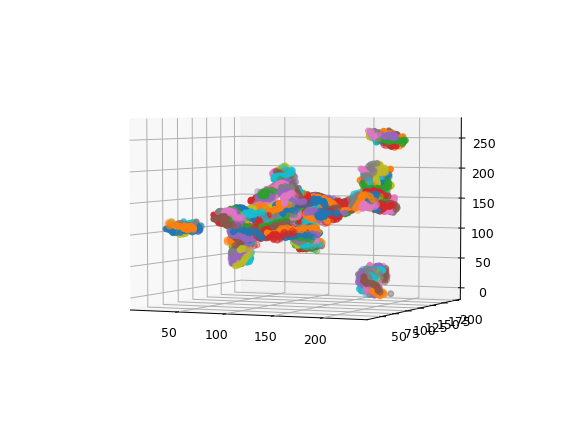

In [47]:
morphoscanner.plot.plot_peptide_list(prod.frames[4000]['frame_dict'], [e for e in prod.frames[0]['frame_dict']])

In [49]:
prod.number_of_frames

4016

In [48]:
prod1 = trajectory(prod1_gro, prod1_xtc)

In [50]:
prod1.compose_database(peptide_length=18, interval=99, start_from=prod.number_of_frames)

997it [00:18, 53.89it/s]


In [53]:
prod1.analyze_inLoop()

0it [00:00, ?it/s]

processing started...


162it [00:02, 59.78it/s]
100%|██████████| 138/138 [00:00<00:00, 289117.86it/s]
0it [00:00, ?it/s]

Time needed to analyze frame 4059 is 26.965931 seconds


162it [00:02, 60.36it/s]
100%|██████████| 132/132 [00:00<00:00, 329552.46it/s]
0it [00:00, ?it/s]

Time needed to analyze frame 4158 is 26.465782 seconds


162it [00:02, 60.73it/s]
100%|██████████| 134/134 [00:00<00:00, 160352.85it/s]
0it [00:00, ?it/s]

Time needed to analyze frame 4257 is 26.233644 seconds


162it [00:02, 56.96it/s]
100%|██████████| 161/161 [00:00<00:00, 22594.54it/s]
0it [00:00, ?it/s]

Time needed to analyze frame 4356 is 114.345187 seconds


162it [00:02, 62.12it/s]
100%|██████████| 135/135 [00:00<00:00, 351914.88it/s]
0it [00:00, ?it/s]

Time needed to analyze frame 4455 is 26.497896 seconds


162it [00:02, 61.81it/s]
100%|██████████| 139/139 [00:00<00:00, 290053.86it/s]
0it [00:00, ?it/s]

Time needed to analyze frame 4554 is 26.601152 seconds


162it [00:02, 62.27it/s]
100%|██████████| 140/140 [00:00<00:00, 323171.47it/s]
0it [00:00, ?it/s]

Time needed to analyze frame 4653 is 26.580416 seconds


162it [00:02, 62.21it/s]
100%|██████████| 138/138 [00:00<00:00, 243301.37it/s]
0it [00:00, ?it/s]

Time needed to analyze frame 4752 is 26.571040 seconds


162it [00:02, 61.82it/s]
100%|██████████| 138/138 [00:00<00:00, 296371.71it/s]
0it [00:00, ?it/s]

Time needed to analyze frame 4851 is 26.282960 seconds


162it [00:02, 62.24it/s]
100%|██████████| 141/141 [00:00<00:00, 313572.04it/s]

Time needed to analyze frame 4950 is 27.381677 seconds
Total time to analyze dataset is 353.927099 seconds


<IPython.core.display.Javascript object>


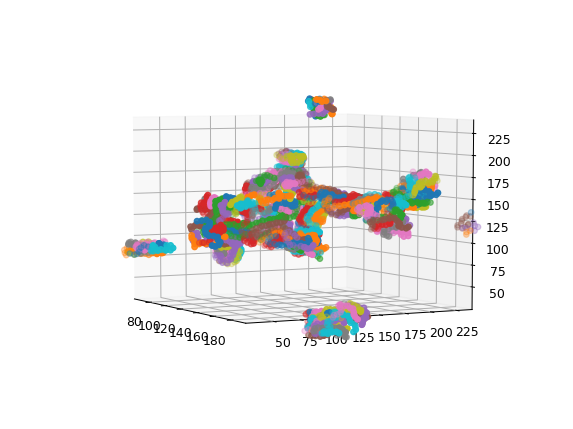

In [83]:
morphoscanner.plot.plot_peptide_list(prod1.frames[4356]['frame_dict'], [e for e in prod1.frames[4356]['frame_dict']])

In [54]:
prod1.sampled_frames

[4059, 4158, 4257, 4356, 4455, 4554, 4653, 4752, 4851, 4950]

In [59]:
prod1.subgraph_length_peptide()

In [60]:
prod1.subgraph_length_seed()

In [61]:
prod1.get_sense()

KeyError: 'antiparallel'

In [79]:
antiparallel = len(prod1.frames[4356]['frame_data'].groupby('sense').get_group('antiparallel'))

KeyError: 'antiparallel'

In [78]:
antiparallel

214

In [82]:
prod1.frames[4356]['frame_data']

,peptide1,peptide2,NCC Value,shift index,contacts,sense
0,0,1,0.235702,17,324.0,parallel
1,0,2,0.235702,17,324.0,parallel
2,0,3,0.235702,17,324.0,parallel
3,0,4,0.235702,17,324.0,parallel
4,0,5,0.235702,17,324.0,parallel
...,...,...,...,...,...,...
13036,158,160,0.235702,17,324.0,parallel
13037,158,161,0.235702,17,324.0,parallel
13038,159,160,0.235702,17,324.0,parallel
13039,159,161,0.235702,17,324.0,parallel


In [94]:
prod1.frames[4356]

{'frame_dict': {0: {0: array([173.564  , 261.58698, 131.517  ], dtype=float32),
   1: array([171.513,   0.203, 132.912], dtype=float32),
   2: array([173.497    ,   2.7559998, 133.526    ], dtype=float32),
   3: array([175.055    ,   5.7159996, 134.386    ], dtype=float32),
   4: array([177.25     ,   7.2279997, 131.958    ], dtype=float32),
   5: array([177.37999,   6.95   , 128.587  ], dtype=float32),
   6: array([179.55598  ,   4.4849997, 127.978    ], dtype=float32),
   7: array([178.297,   2.566, 126.002], dtype=float32),
   8: array([180.234,   0.735, 123.423], dtype=float32),
   9: array([179.305   ,   2.208   , 119.855995], dtype=float32),
   10: array([182.086,   2.6  , 118.456], dtype=float32),
   11: array([183.20099,   5.981  , 118.062  ], dtype=float32),
   12: array([185.866,   7.54 , 117.234], dtype=float32),
   13: array([184.643    ,   8.7699995, 113.849    ], dtype=float32),
   14: array([186.69699,   9.234  , 111.67999], dtype=float32),
   15: array([187.23299  ,   7

In [87]:
err4356 = morphoscanner.topology.get_coordinate_dict_from_trajectory(prod1_gro, prod1_xtc, peptide_length=18, start_from=4016, interval=99)


997it [00:16, 59.43it/s]


In [93]:
for i in err4356[4356]:
    print(len(err4356[4356][i]))
    #for e in err4356[4356][i]:
        

18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18


In [98]:
err_tens = morphoscanner.distance_tensor.get_coordinate_tensor_from_dict(err4356[4356])

In [99]:
dist = morphoscanner.distance_tensor.compute_euclidean_norm_torch(err_tens)

162it [00:02, 60.93it/s]


In [100]:
contact = morphoscanner.distance.compute_contact_maps_as_array(dist)

In [105]:
denoised, datafr = morphoscanner.denoise.denoise_contact_maps(contact)

100%|██████████| 161/161 [00:00<00:00, 22783.59it/s]


In [101]:
dist.shape

(162, 162, 18, 18)

In [102]:
contact.shape

(162, 162, 18, 18)

In [121]:
dist[0][0]

array([[0.0000000e+00, 2.6139575e+02, 2.5883875e+02, 2.5589137e+02,
        2.5438606e+02, 2.5468240e+02, 2.5719611e+02, 2.5912289e+02,
        2.6106274e+02, 2.5970441e+02, 2.5945609e+02, 2.5614120e+02,
        2.5474536e+02, 2.5367561e+02, 2.5347189e+02, 2.5544081e+02,
        2.5860632e+02, 2.6173141e+02],
       [2.6139575e+02, 0.0000000e+00, 3.2906117e+00, 6.7169328e+00,
        9.1198616e+00, 9.9321918e+00, 1.0362191e+01, 9.9675255e+00,
        1.2898946e+01, 1.5336333e+01, 1.8069744e+01, 1.9761469e+01,
        2.2486280e+01, 2.4681725e+01, 2.7620758e+01, 2.9665585e+01,
        3.0141722e+01, 2.9177929e+01],
       [2.5883875e+02, 3.2906117e+00, 0.0000000e+00, 3.4539380e+00,
        6.0447550e+00, 7.5534554e+00, 8.3950319e+00, 8.9263477e+00,
        1.2310121e+01, 1.4862653e+01, 1.7346424e+01, 1.8539021e+01,
        2.1007254e+01, 2.3400555e+01, 2.6333349e+01, 2.8647644e+01,
        2.9472048e+01, 2.8693695e+01],
       [2.5589137e+02, 6.7169328e+00, 3.4539380e+00, 0.0000000e+00,

<IPython.core.display.Javascript object>


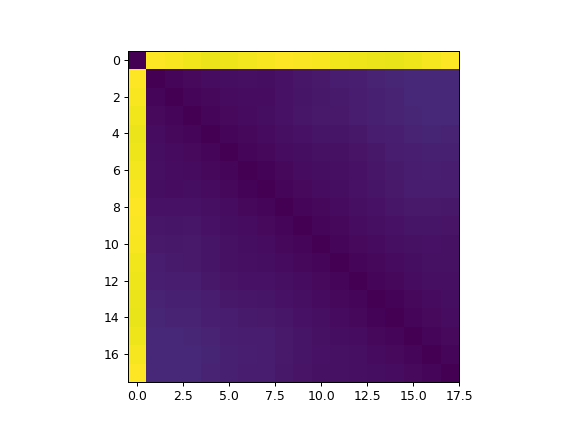

In [122]:
plt.imshow(dist[0][0])

In [111]:
plt.close()

In [114]:
dist[0][1]

array([[260.01834  , 261.7835   , 261.10504  , 261.19507  , 262.66205  ,
         26.899117 ,  23.591908 ,  21.812052 , 260.9893   , 257.9226   ,
        255.79477  , 254.99977  , 252.95981  , 252.028    , 250.1225   ,
        249.66313  , 250.07986  , 249.10368  ],
       [ 19.457085 ,  20.821226 ,  22.811386 ,  26.170862 ,  28.97898  ,
        262.94943  , 261.18436  , 263.99734  ,  25.19006  ,  24.465218 ,
         25.925524 ,  25.618597 ,  28.5274   ,  27.807795 ,  25.649075 ,
         24.189034 ,  23.340883 ,  25.615547 ],
       [ 20.882298 ,  22.218552 ,  23.92338  ,  27.192026 ,  29.964693 ,
        260.50543  , 258.71835  , 261.51825  ,  25.851288 ,  24.883007 ,
         25.956844 ,  25.301464 ,  27.943861 ,  26.844315 ,  24.493782 ,
         22.70841  ,  21.586853 ,  23.60333  ],
       [ 22.71357  ,  24.099566 ,  25.561811 ,  28.717237 ,  31.474567 ,
        257.6933   , 255.8831   , 258.66867  ,  27.142996 ,  25.898842 ,
         26.588297 ,  25.637955 ,  27.963425 ,  26.51

In [124]:
dist_old = morphoscanner.distance.compute_distance_maps_from_coordinate_dict(err4356[4356])

100%|██████████| 162/162 [02:34<00:00,  1.05it/s]


In [151]:
datafr[150:200]

,peptide1,peptide2,NCC Value,shift index,contacts,sense
150,0,151,0.235702,17,324.0,parallel
151,0,152,0.235702,17,324.0,parallel
152,0,153,0.235702,17,324.0,parallel
153,0,154,0.235702,17,324.0,parallel
154,0,155,0.235702,17,324.0,parallel
155,0,156,0.235702,17,324.0,parallel
156,0,157,0.235702,17,324.0,parallel
157,0,158,0.235702,17,324.0,parallel
158,0,159,0.235702,17,324.0,parallel
159,0,160,0.235702,17,324.0,parallel


<IPython.core.display.Javascript object>


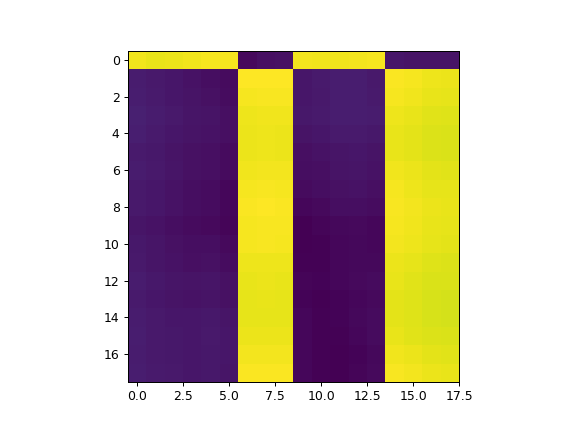

In [139]:
plt.imshow(contact[0][2])

In [129]:
plt.close()

In [133]:
dist_old[0][1]

array([[260.01830881, 261.78351937, 261.10503904, 261.19508442,
        262.66206255,  26.89914819,  23.59227462,  21.81210107,
        260.98932376, 257.92262315, 255.79479022, 254.99981519,
        252.95981256, 252.02800873, 250.1224876 , 249.66312623,
        250.07985087, 249.10371516],
       [ 19.45704907,  20.8211934 ,  22.81133028,  26.17085841,
         28.97907749, 262.9494242 , 261.18434236, 263.99736029,
         25.18998561,  24.46513504,  25.92548896,  25.61857892,
         28.52731962,  27.80785143,  25.64918068,  24.18898064,
         23.34085626,  25.61551185],
       [ 20.8823788 ,  22.2185766 ,  23.92347789,  27.19203418,
         29.9648427 , 260.50543202, 258.71834189, 261.51823558,
         25.85138757,  24.88298089,  25.95686719,  25.30159154,
         27.94392801,  26.84450383,  24.49397563,  22.70853123,
         21.58699503,  23.60324823],
       [ 22.7135178 ,  24.09940132,  25.56176507,  28.71720745,
         31.47466585, 257.69329313, 255.88309035, 258.668

<IPython.core.display.Javascript object>


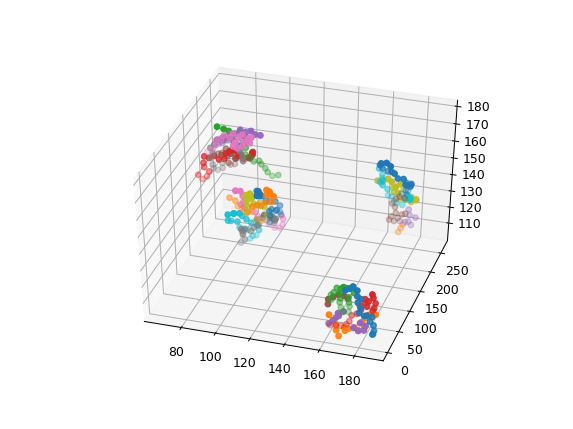

In [143]:
morphoscanner.plot.plot_peptide_list(err4356[4356], [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20])

In [152]:
normalized_cross_correlation_results, df = morphoscanner.cross_correlation.cross_correlation_function_for_dataset_with_dataframe(contact)

In [154]:
len(normalized_cross_correlation_results)

161

In [ ]:
prod.

In [155]:
df

,peptide1,peptide2,NCC Value,shift index,contacts,sense
0,0,1,0.235702,17,324.0,parallel
1,0,2,0.235702,17,324.0,parallel
2,0,3,0.235702,17,324.0,parallel
3,0,4,0.235702,17,324.0,parallel
4,0,5,0.235702,17,324.0,parallel
...,...,...,...,...,...,...
13036,158,160,0.235702,17,324.0,parallel
13037,158,161,0.235702,17,324.0,parallel
13038,159,160,0.235702,17,324.0,parallel
13039,159,161,0.235702,17,324.0,parallel


In [156]:
def normalized_cross_correlation_function(contact_map, minimum_contact=2):
    '''
    Calculate normalized cross correlation function between a contact map and an ideal map.

    Arguments : contact map, as output from get_contact_maps function
                shift_matrix_stack, as output from shift_matrix_maker function

    Return : a list [ncc_value, index (in the shift_matrix_stack) of the shift matrix
                that is matching the contact map

            '''
    shift_matrix_library = morphoscanner.cross_correlation.shift_library_maker(contact_map)

    cross_correlation_values = []
    max_val = []
    sum_contact_map = np.sum(contact_map)

    if sum_contact_map < minimum_contact:
        pass

    else:
        for sense in shift_matrix_library:
            for index, z in enumerate(shift_matrix_library[sense]):

                shift_matrix = shift_matrix_library[sense][index]
                sum_shift_matrix = np.sum(shift_matrix)
                ncc_value = (np.sum((contact_map * shift_matrix))/((np.sqrt(sum_contact_map))*(np.sqrt(sum_shift_matrix))))  # normalized cross correlation function of contact matrix and shift matrix
                cross_correlation_values.append([ncc_value, index, sum_contact_map, sense])

            max_val = max(cross_correlation_values) # get only the best match (highest value of ncc)

    return max_val

In [157]:
  #contact_array = frame_contact
def cross_correlation_function_for_dataset_with_dataframe(contact_array):
    '''Perform Normalized Cross Correlation function on the dataset
        to check for contact. Get a dict for processing and a pandas.DataFrame
        for data analysis

        Input: contact maps

        Output: contact_dict,         for further processing
                pandas.DataFrame,     for data analysis


    '''
    contact_dict = {}

    for row in range(contact_array.shape[0]):

        for col in range((row+1), contact_array.shape[1]):
            best_match = []
            best_match = morphoscanner.cross_correlation.normalized_cross_correlation_function(contact_array[row][col])

            if len(best_match) == 0:
                pass

            else:
                if row in contact_dict:
                    contact_dict[row].append([row, col, best_match])

                else:
                    contact_dict[row] = [[row, col, best_match]]

    contact_list = morphoscanner.utility.contact_list_from_dict(contact_dict)

    columns_names = ['peptide1', 'peptide2', 'NCC Value', 'shift index', 'contacts', 'sense']

    df = pd.DataFrame(contact_list, columns=columns_names)

    return contact_dict, df


In [159]:
aaa = cross_correlation_function_for_dataset_with_dataframe(contact)

In [165]:
contact_array = contact

contact_dict = {}

for row in range(contact_array.shape[0]):

    for col in range((row+1), contact_array.shape[1]):
        best_match = []
        best_match = morphoscanner.cross_correlation.normalized_cross_correlation_function(contact_array[row][col])

        print(best_match)

        if len(best_match) == 0:
            pass

        
        else:
            if row in contact_dict:
                contact_dict[row].append([row, col, best_match])

            else:
                contact_dict[row] = [[row, col, best_match]]

            #best_match = []
            #best_match = morphoscanner.cross_correlation.normalized_cross_correlation_function(contact_array[row][col])

[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.2357022

[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.2357022

[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.2357022

[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.2357022

[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.2357022

[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.2357022

[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.2357022

[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.2357022

[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.2357022

[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.2357022

[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.2357022

[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.2357022

[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.2357022

[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.2357022

[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.2357022

[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.2357022

[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.2357022

[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.2357022

[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.2357022

[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.2357022

[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.2357022

[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.2357022

[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.2357022

[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.2357022

[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.2357022

[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.2357022

[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.2357022

[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.2357022

[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.2357022

[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.2357022

[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.2357022

[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.2357022

[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.2357022

[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.2357022

[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.2357022

[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.2357022

[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.2357022

[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.2357022

[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.2357022

[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.2357022

[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.2357022

[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.2357022

[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.2357022

[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.2357022

[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.23570226039551587, 17, 324.0, 'parallel']
[0.2357022

In [167]:
contact_dict

{0: [[0, 1, [0.23570226039551587, 17, 324.0, 'parallel']],
  [0, 2, [0.23570226039551587, 17, 324.0, 'parallel']],
  [0, 3, [0.23570226039551587, 17, 324.0, 'parallel']],
  [0, 4, [0.23570226039551587, 17, 324.0, 'parallel']],
  [0, 5, [0.23570226039551587, 17, 324.0, 'parallel']],
  [0, 6, [0.23570226039551587, 17, 324.0, 'parallel']],
  [0, 7, [0.23570226039551587, 17, 324.0, 'parallel']],
  [0, 8, [0.23570226039551587, 17, 324.0, 'parallel']],
  [0, 9, [0.23570226039551587, 17, 324.0, 'parallel']],
  [0, 10, [0.23570226039551587, 17, 324.0, 'parallel']],
  [0, 11, [0.23570226039551587, 17, 324.0, 'parallel']],
  [0, 12, [0.23570226039551587, 17, 324.0, 'parallel']],
  [0, 13, [0.23570226039551587, 17, 324.0, 'parallel']],
  [0, 14, [0.23570226039551587, 17, 324.0, 'parallel']],
  [0, 15, [0.23570226039551587, 17, 324.0, 'parallel']],
  [0, 16, [0.23570226039551587, 17, 324.0, 'parallel']],
  [0, 17, [0.23570226039551587, 17, 324.0, 'parallel']],
  [0, 18, [0.23570226039551587, 17, 3

In [180]:
contact_dict[0]

[[0, 1, [0.23570226039551587, 17, 324.0, 'parallel']],
 [0, 2, [0.23570226039551587, 17, 324.0, 'parallel']],
 [0, 3, [0.23570226039551587, 17, 324.0, 'parallel']],
 [0, 4, [0.23570226039551587, 17, 324.0, 'parallel']],
 [0, 5, [0.23570226039551587, 17, 324.0, 'parallel']],
 [0, 6, [0.23570226039551587, 17, 324.0, 'parallel']],
 [0, 7, [0.23570226039551587, 17, 324.0, 'parallel']],
 [0, 8, [0.23570226039551587, 17, 324.0, 'parallel']],
 [0, 9, [0.23570226039551587, 17, 324.0, 'parallel']],
 [0, 10, [0.23570226039551587, 17, 324.0, 'parallel']],
 [0, 11, [0.23570226039551587, 17, 324.0, 'parallel']],
 [0, 12, [0.23570226039551587, 17, 324.0, 'parallel']],
 [0, 13, [0.23570226039551587, 17, 324.0, 'parallel']],
 [0, 14, [0.23570226039551587, 17, 324.0, 'parallel']],
 [0, 15, [0.23570226039551587, 17, 324.0, 'parallel']],
 [0, 16, [0.23570226039551587, 17, 324.0, 'parallel']],
 [0, 17, [0.23570226039551587, 17, 324.0, 'parallel']],
 [0, 18, [0.23570226039551587, 17, 324.0, 'parallel']],
 

<IPython.core.display.Javascript object>


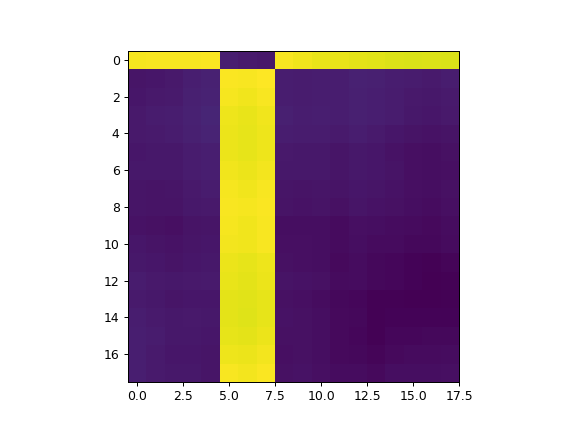

In [179]:
plt.imshow(dist[0][1])

In [185]:
uno = err4356[4356][0][0]

In [183]:
due = err4356[4356][0][1]

In [186]:
morphoscanner.distance.get_euclidean_distance(uno, due)

261.3957412108983